In [2]:
import datetime
import smtplib
from email.mime.text import MIMEText
import QUANTAXIS as QA

try:
    assert QA.__version__ >= '1.1.0'
except AssertionError:
    print('pip install QUANTAXIS >= 1.1.0 请升级QUANTAXIS后再运行此示例')
    import QUANTAXIS as QA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abupy
from abupy import ABuRegUtil
from concurrent.futures import ThreadPoolExecutor
from functools import reduce
import warnings

read_dictionary = np.load('/media/sf_GIT/vest/liutong.npy', allow_pickle=True).item()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
import mpl_finance as mpf
index = 'datetime'
formate = '%Y-%m-%dT%H:%M:%S'
dayindex = 'date'
dayformate = '%Y-%m-%d'
startday='2019-01-01'

pw=0.47  #backtest win ratio
rw=1.15 #sell when got 15% increase
rl=0.97 #end if loss 0.03 of holdings
def percSet(pw,rw,rl):
    #kelly rule of holdings
    return (pw/rl)-(1-pw)/rw
#percSet(pw,rw,rl)

def MACACalculate(sample):
    rate = 0.015
    sample['EMA12'] = QA.EMA(sample.close, 12)
    sample['EMA13'] = QA.EMA(sample.close, 13)
    sample['optimism'] = sample.high - sample.EMA13
    sample['pessmist'] = sample.low - sample.EMA13
    sample['up'] = sample.EMA13 * (1 + rate)
    sample['down'] = sample.EMA13 * (1 - rate)
    sample['EMA26'] = QA.EMA(sample.close, 26)
    sample['MACDQ'] = sample['EMA12'] - sample['EMA26']
    sample['MACDSIG'] = QA.EMA(sample['MACDQ'], 9)
    sample['MACDBlock'] = sample['MACDQ'] - sample['MACDSIG']
    sample['VolumeEMA'] = QA.EMA(sample.volume, 5)
    sroc = []
    for i in range(sample.shape[0]):
        if (i - 21 > 0 and sample.iloc[i].EMA13 != None and sample.iloc[i - 21].EMA13 != None):
            # print(sample.iloc[i].EMA13/sample.iloc[i-21].EMA13)
            sroc.append((sample.iloc[i].EMA13 / sample.iloc[i - 21].EMA13) * 100)
        else:
            sroc.append(100)
    sample['SROC'] = sroc
    size = sample.shape[0]
    single = [0]
    for i in range(sample.shape[0]):
        if (sample.MACDBlock[i - 1] < 0 and sample.MACDBlock[i] >= 0 and i - 1 >= 0):
            print(sample.index.get_level_values('date')[i])
            single.append(1)
        elif (sample.MACDBlock[i - 1] >= 0 and sample.MACDBlock[i] < 0 and i):
            single.append(3)
        else:
            single.append(0)
    for i in range(sample.shape[0]):
        if (single[i] == 1 and i + 3 < size):
            single[i + 3] = 3
    single.pop()
    sample['single'] = single

    return sample


def candlestruct(sample):
    import matplotlib.dates as mpd
    quotes = []
    pydate_array = sample.index.get_level_values('date').to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array)
    # date_only_series = pd.Series(date_only_array)
    N = sample.index.get_level_values('date').shape[0]
    ind = np.arange(N)
    for i in range(len(sample)):
        li = []
        # datet=datetime.datetime.strptime(sample.index.get_level_values('date'),'%Y%m%d')   #字符串日期转换成日期格式
        # datef=mpd.date2num(datetime.datetime.strptime(date_only_array[i],'%Y-%m-%d'))
        datef = ind[i]  # 日期转换成float days
        open_p = sample.open[i]
        close_p = sample.close[i]
        high_p = sample.high[i]
        low_p = sample.low[i]
        li = [datef, open_p, close_p, high_p, low_p]
        t = tuple(li)
        quotes.append(t)
    return quotes


def MACDPLOT(sample):
    quotes = candlestruct(sample)
    N = sample.index.get_level_values('date').shape[0]
    ind = np.arange(N)

    def format_date(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, N - 1)
        return sample.index.get_level_values('date')[thisind].strftime('%Y-%m-%d')

    fig = plt.figure()
    fig.set_size_inches(20.5, 12.5)
    # plt.xlabel('Trading Day')
    # plt.ylabel('MACD EMA')
    ax2 = fig.add_subplot(4, 1, 1)
    ax2.set_title("candlestick", fontsize='xx-large', fontweight='bold')

    # fig,ax=plt.subplots()
    # mpf.candlestick_ochl(ax2,quotes,width=0.2,colorup='r',colordown='g',alpha=1.0)
    # ax2.xaxis_date()
    # plt.setp(plt.gca().get_xticklabels(),rotation=30)
    # ax2.plot(ind,sample.close,'b-',marker='*')
    mpf.candlestick_ochl(ax2, quotes, width=0.6, colorup='r', colordown='g', alpha=1.0)
    ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    ax2.plot(ind, sample.up, 'r-')
    ax2.plot(ind, sample.down, 'b-')
    ax2.grid(True)
    # t.legend()
    fig.autofmt_xdate()

    ax4 = fig.add_subplot(4, 1, 2, sharex=ax2)
    ax4.set_title("EMA13/SROC21", fontsize='xx-large', fontweight='bold')
    # ax1 = ax2.twinx()   #not working like it's
    ax4.plot(ind, sample.SROC, 'r-')
    ax4.grid(True)
    ax4.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()

    ax3 = fig.add_subplot(4, 1, 4, sharex=ax2)
    ax3.set_title("volume EMA", fontsize='xx-large', fontweight='bold')
    # ax1 = ax2.twinx()   #not working like it's
    ax3.bar(ind, sample.volume)
    ax3.plot(ind, sample.VolumeEMA, 'r-')
    ax3.grid(True)
    ax3.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()

    ax1 = fig.add_subplot(4, 1, 3, sharex=ax2)
    ax1.set_title('macd', fontsize='xx-large', fontweight='bold')
    ax1.grid(True)
    ax1.plot(ind, sample.MACDQ, 'r-', marker='*')
    ax1.plot(ind, sample.MACDSIG, 'o-')
    ax1.bar(ind, sample.MACDBlock)
    ax1.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    # ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
    fig.autofmt_xdate()
    plt.legend()

    code = sample.index.get_level_values('code')[0]

    plt.savefig('/home/mildone/monitor/' + 'Trend' + code + '.png')
    plt.show()
    plt.close()


def amountAnalyse(buydata):
    """
    @buydata as pdDataFrame
    e.g. buydata = QA.QA_fetch_get_stock_transaction_realtime('pytdx','600797') get current day's transaction
    e.g. data1=QA.QAFetch.QATdx.QA_fetch_get_stock_transaction('600797','2019-01-01','2019-04-11') get transaction among period of time

    """
    sellone = buydata[buydata['buyorsell'] == 1]
    sellone['amount'] = sellone['price'] * sellone['vol']
    sellone.sort_values("vol", inplace=True, ascending=False)

    buyone = buydata[buydata['buyorsell'] == 0]
    buyone['amount'] = buyone['price'] * buyone['vol']
    buyone.sort_values("vol", inplace=True, ascending=False)
    # print("Top buyer vol")
    # buyone[buyone['vol']>10]
    print("Top Seller vol")
    sellone.head(100)


def getStocklist():
    """
    get all stock as list
    usage as:
    QA.QA_util_log_info('GET STOCK LIST')
    stocks=getStocklist()
    """
    data = QA.QAFetch.QATdx.QA_fetch_get_stock_list('stock')
    stock = data['code'].index
    stocklist = []
    for code in stock:
        stocklist.append(code[0])
    return stocklist


def loadLocalData(stocks, start_date='2018-03-15', end_date='2019-09-07'):
    """
    data() as pdDataFrame
    stocks could be list of all the stock or some. if you pass single one e.g. 000001 it will get one only
    to get dedicated stock, using below method, and notice stockp() will be dataFrame
    stockp = data.select_code(stock)


    """
    QA.QA_util_log_info('load data from local DB')
    data = QA.QA_fetch_stock_day_adv(stocks, start_date, end_date)
    return data


def loadFromCopy(file):
    """
    loaddata from file copy
    """
    return pd.DataFrame(pd.read_csv(file))


def calAngle(df):
    """
    trend angle based on provided dataframe
    """
    return ABuRegUtil.calc_regress_deg(df.close.values, show=False)


def getData(df, code):
    """
    split data per code from all market data
    """
    return df[df.code == code].reset_index(drop=True)


def trendBreak(pdDataFrame):
    """
    trendBreak based on provdied market data
    """

    from abupy import pd_rolling_max
    from abupy import pd_expanding_max
    # 当天收盘价格超过N1天内最高价格作为买入信号
    N1 = 20
    # 当天收盘价格超过N2天内最低价格作为卖出信号
    N2 = 15
    kl_pd = pdDataFrame
    # 通过rolling_max方法计算最近N1个交易日的最高价
    # kl_pd['n1_high'] = pd.rolling_max(kl_pd['high'], window=N1)
    kl_pd['n1_high'] = pd_rolling_max(kl_pd['high'], window=N1)
    # 表7-4所示

    # expanding_max
    # expan_max = pd.expanding_max(kl_pd['close'])
    expan_max = pd_expanding_max(kl_pd['close'])
    # fillna使用序列对应的expan_max
    kl_pd['n1_high'].fillna(value=expan_max, inplace=True)
    # 表7-5所示
    # print('kl_pd[0:5]:\n', kl_pd[0:5])

    from abupy import pd_rolling_min, pd_expanding_min
    # 通过rolling_min方法计算最近N2个交易日的最低价格
    # rolling_min与rolling_max类似
    # kl_pd['n2_low'] = pd.rolling_min(kl_pd['low'], window=N2)
    kl_pd['n2_low'] = pd_rolling_min(kl_pd['low'], window=N2)
    # expanding_min与expanding_max类似
    # expan_min = pd.expanding_min(kl_pd['close'])
    expan_min = pd_expanding_min(kl_pd['close'])
    # fillna使用序列对应的eexpan_min
    kl_pd['n2_low'].fillna(value=expan_min, inplace=True)

    # 当天收盘价格超过N天内的最高价或最低价, 超过最高价格作为买入信号买入股票持有
    buy_index = kl_pd[kl_pd['close'] > kl_pd['n1_high'].shift(1)].index
    kl_pd.loc[buy_index, 'signal'] = 1

    # 当天收盘价格超过N天内的最高价或最低价, 超过最低价格作为卖出信号
    sell_index = kl_pd[kl_pd['close'] < kl_pd['n2_low'].shift(1)].index
    kl_pd.loc[sell_index, 'signal'] = 0

    # kl_pd.signal.value_counts().plot(kind='pie', figsize=(5, 5))
    #plt.show()

    """
        将信号操作序列移动一个单位，代表第二天再将操作信号执行，转换得到持股状态
        这里不shift(1)也可以，代表信号产生当天执行，但是由于收盘价格是在收盘后
        才确定的，计算突破使用了收盘价格，所以使用shift(1)更接近真实情况
    """
    kl_pd['keep'] = kl_pd['signal'].shift(1)
    kl_pd['keep'].fillna(method='ffill', inplace=True)
    return kl_pd

    # 计算基准收益
    # kl_pd['benchmark_profit'] = np.log(
    # kl_pd['close'] / kl_pd['close'].shift(1))

    # 计算使用趋势突破策略的收益
    # kl_pd['trend_profit'] = kl_pd['keep'] * kl_pd['benchmark_profit']

    # 可视化收益的情况对比
    # kl_pd[['benchmark_profit', 'trend_profit']].cumsum().plot(grid=True,
    #                                                      figsize=(
    #                                                          14, 7))
    # plt.show()
    # kl_pd[['n2_low','n1_high','close']].plot(grid=True,figsize=(14,7))
    # kl_pd.close.plot(grid=True,figsize=(14.7))
    # plt.show()






def init_change(df):
    # change first (d[i].close-d[i-1].close)/d[i-1].close
    pp_array = [float(close) for close in df.close]
    temp_array = [(price1, price2) for price1, price2 in zip(pp_array[:-1], pp_array[1:])]
    change = list(map(lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp), temp_array))
    change.insert(0, 0)
    df['change'] = change
    # amplitude (d[i].high-d[i].low)/d[i-1].close)
    amp_arry = [float(amp) for amp in (df.high - df.low)]
    amp_temp = [(price1, price2) for price1, price2 in zip(amp_arry[:-1], pp_array[1:])]
    amplitude = list(map(lambda pp: reduce(lambda a, b: round(a / b, 3), pp), amp_temp))
    amplitude.insert(0, 0)
    df['amplitude'] = amplitude
    # sratio = QA.QA_fetch_get_stock_info(df.index.get_level_values('code')[0]).liutongguben[0]
    sratio = read_dictionary[df.index.get_level_values('code')[0]]
    df['SR'] = df['volume'] / sratio * 100


def init_trend(df, period=7):
    """
    period can be set based on situation.
    detect the angle change form negative to positive
    """
    trend = []
    ratio = []
    for i in range(0, df.shape[0]):
        # print(i)
        if (i < period):
            trend.append(calAngle(df.iloc[:period]))
            ratio.append(df.iloc[i].amount * period / sum(df.iloc[0:period].amount))
        else:
            trend.append(calAngle(df.iloc[i - period + 1:i + 1]))
            ratio.append(df.iloc[i].amount * 5 / sum(df.iloc[i - 5:i].amount))
    df['trend'] = trend
    df['amountRatio'] = ratio

def init_trendMACD(df, period=7):
    """
    period can be set based on situation.
    detect the angle change form negative to positive
    """
    trend = []
    ratio = []
    for i in range(0, df.shape[0]):
        # print(i)
        if (i < period):
            trend.append(calAngle(df.iloc[:period]))
            ratio.append(df.iloc[i].amount * period / sum(df.iloc[0:period].amount))
        else:
            trend.append(calAngle(df.iloc[i - period + 1:i + 1]))
            ratio.append(df.iloc[i].amount * 5 / sum(df.iloc[i - 5:i].amount))
    df['trend'] = trend
    df['amountRatio'] = ratio
    return df

"""

def trendSingle(df):

    buydate=[]
    for i in range(0,df.shape[0]):
        if(df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude<0.07 and df.iloc[i].change<0.03 
          and df.iloc[i].change>0.01):
            buydate.append((i,df.iloc[i].date))
    return buydate
"""


def trendSingle(df, period=7):
    """
    @paramater dataframe
    return True or False
    Justification:
    1. latest 20 days angle >0
    2. change (0.1~0.3)
    3.

    """
    # df['trend']=0
    # df['amountRatio']=0
    # trend=0
    # amountRatio=0
    keep = 5
    init_change(df)
    init_trend(df)
    single = [0, 0]
    # temp =[]
    for i in range(1, df.shape[0]):
        """
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            trend=calAngle(df.iloc[:period])
            #print(trend)
            #ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
            amountRatio=df.iloc[i].amount*period/sum(df.iloc[0:period].amount)
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            trend=calAngle(df.iloc[i-period+1:i+1])
            #print(trend)
            #print(calAngle(df.iloc[i-period+1:i+1]))
            #ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            #print(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            amountRatio=df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount)
        """
        if (1.5 > df.iloc[i].amountRatio > 1 and df.iloc[i].trend > 1 and df.iloc[i].amplitude > 0.05
                and 0.01 < df.iloc[i].change < 0.03 and df.iloc[i].SR < 0.05):
            single.append(1)
        else:
            single.append(0)
    # single.append(0)
    # single.extend(temp[:-1])
    # print("done here")
    # single.insert(0,0)
    single.pop()
    # print(single)
    size = len(single)
    # for simple purpose, set last (Keep) as 0,simple take 3 days as holding max

    # print("checking operation single")
    for i in range(0, size - 5):
        if single[i] == 1:
            bar = df.iloc[i].open * 1.2
            j = i
            if (df.iloc[j + 1].change > 0 and df.iloc[j + 1].close < bar):
                single[j + 1] = 0
            else:
                single[j + 1] = 3
                continue
            if ((df.iloc[j + 2].change > 0 and df.iloc[j + 2].close < bar) or
                    (df.iloc[j + 2].change < 0 and df.iloc[j + 2].close > df.iloc[i].open)):
                single[j + 2] = 0

            else:
                single[j + 2] = 3
                continue
            if ((df.iloc[j + 3].change > 0 and df.iloc[j + 3].close < bar)
                    or (df.iloc[j + 3].change < 0 and df.iloc[j + 3].close > df.iloc[i].open)):
                single[j + 3] = 0
            else:
                single[j + 3] = 3
                continue
            if ((df.iloc[j + 4].change > 0 and df.iloc[j + 4].close < bar)
                    or (df.iloc[j + 4].change < 0 and df.iloc[j + 4].close > df.iloc[i].open)):
                single[j + 4] = 0
            else:
                single[j + 4] = 3
                continue
            single[j + 5] = 3

    single[-5:] = [0, 0, 0, 0, 0]

    df['single'] = single
    # df['single']=df['keep'].shift(1)
    # df['single'].fillna(method='ffill',inplace=True)
    print(df.index.levels[1])
    return df

def nineTurn(sample, period = 7):
    sample['highEMAS25'] = QA.EMA(sample.high, 25)
    sample['lowEMAS25'] = QA.EMA(sample.low, 25)
    sample['Stunel'] = sample.highEMAS25 - sample.lowEMAS25
    sample['highEMAL90'] = QA.EMA(sample.high, 90)
    sample['lowEMAL90'] = QA.EMA(sample.low, 90)
    single = [0 for _ in range(13)]
    N = sample.shape[0]
    for i in range(13, N):
        Raise = 1
        Down = 1
        # print('round {}'.format(i))
        for j in range(i - 8, i + 1):
            # print('round {}, index {}'.format(i,j))
            if (sample.close[j] > sample.close[j - 4]):
                Raise = Raise * 1
                Down = Down * 0
            else:
                Raise = Raise * 0
                Down = Down * 1
        # if(Raise and max(sample.close[i],sample.close[i-1])>max(sample.close[i-2],sample.close[i-3])):
        # if (Raise and sample.close[i] > sample.close[i - 2]):
        if (Down and sample.close[i]<sample.lowEMAS25[i]):
            # for n in range(i - 9, i):
            single.append(1)
        else:
            single.append(0)
    for i in range(len(single)):
        if (i+5 < len(single) and single[i]==1):
            single[i+5] = 3
    sample['single'] = single

    return sample


def trendSingleNew(df, period=7):
    # df['trend']=0
    # df['amountRatio']=0
    # trend=0
    # amountRatio=0
    # keep = ３
    init_change(df)
    init_trend(df)
    single = [0, 0]
    # temp =[]
    for i in range(1, df.shape[0]):
        """
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            trend=calAngle(df.iloc[:period])
            #print(trend)
            #ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
            amountRatio=df.iloc[i].amount*period/sum(df.iloc[0:period].amount)
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            trend=calAngle(df.iloc[i-period+1:i+1])
            #print(trend)
            #print(calAngle(df.iloc[i-period+1:i+1]))
            #ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            #print(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            amountRatio=df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount)
        """
        if (1.5 > df.iloc[i].amountRatio > 1 and df.iloc[i].trend > 1 and df.iloc[i].amplitude > 0.05
                and 0.01 < df.iloc[i].change < 0.03 and df.iloc[i].SR < 0.05):
            single.append(1)
        else:
            single.append(0)
    # single.append(0)
    # single.extend(temp[:-1])
    # print("done here")
    # single.insert(0,0)
    single.pop()
    # print(single)
    size = len(single)
    # for simple purpose, set last (Keep) as 0,simple take 3 days as holding max

    # print("checking operation single")
    for i in range(0, size - 3):
        if single[i] == 1:
            bar = df.iloc[i].open * 1.2
            j = i
            if (df.iloc[j + 1].change > 0 and df.iloc[j + 1].close < bar):
                single[j + 1] = 0
            else:
                single[j + 1] = 3
                continue
            if ((df.iloc[j + 2].change > 0 and df.iloc[j + 2].close < bar) or
                    (df.iloc[j + 2].change < 0 and df.iloc[j + 2].close > df.iloc[i].open)):
                single[j + 2] = 0

            else:
                single[j + 2] = 3
                continue

            single[j + 3] = 3

    single[-3:] = [0, 0, 0]

    df['single'] = single
    # df['single']=df['keep'].shift(1)
    # df['single'].fillna(method='ffill',inplace=True)
    print(df.index.levels[1])
    return df


def ana(df):
    # df = loadLocalData(code,'2014-01-01','2019-09-30')
    # df = df.to_qfq()
    init_change(df)
    init_trend(df)
    if (1.5 > df.iloc[-1].amountRatio > 1 and df.iloc[-1].trend > 1 and df.iloc[-1].amplitude > 0.05
            and 0.01 < df.iloc[-1].change < 0.03 and df.iloc[-1].SR < 0.05):
        return True
    else:
        return False


def detect(df):
    init_change(df)
    init_trend(df)
    single = [0, 0]
    # temp =[]
    for i in range(1, df.shape[0]):
        """
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            trend=calAngle(df.iloc[:period])
            #print(trend)
            #ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
            amountRatio=df.iloc[i].amount*period/sum(df.iloc[0:period].amount)
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            trend=calAngle(df.iloc[i-period+1:i+1])
            #print(trend)
            #print(calAngle(df.iloc[i-period+1:i+1]))
            #ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            #print(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            amountRatio=df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount)
        """
        if (1.5 > df.iloc[i].amountRatio > 1 and df.iloc[i].trend > 1 and df.iloc[i].amplitude > 0.05
                and 0.01 < df.iloc[i].change < 0.03 and df.iloc[i].SR < 0.05):
            single.append(1)
        else:
            single.append(0)
    # single.append(0)
    # single.extend(temp[:-1])
    # print("done here")

    # single.insert(0,0)
    single.pop()
    if (single[-1] == 1):
        return True
    else:
        return False


def generateplot(code):
    import datetime
    cur = datetime.datetime.now()
    endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    sample = loadLocalData(code, '2019-08-01', endtime)
    sample = sample.to_qfq()
    sampleData = sample.select_code(code)
    MACACalculate(sampleData.data)
    MACDPLOT(sampleData.data)


def gitAction(candidate):
    from git import Repo
    r = Repo('/home/mildone/monitor')
    commitfile = [r'/home/mildone/monitor/result.log', r'/home/mildone/monitor/data.csv']

    prefix = '/home/mildone/monitor/'
    if (len(candidate) > 0):
        for i in range(len(candidate)):
            generateplot(candidate[i])
            pltfile = prefix + 'Trend' + candidate[i] + '.png'
            commitfile.append(pltfile)
    r.index.add(commitfile)
    cur = datetime.datetime.now()
    msg = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day) + ' commit'
    r.index.commit(msg)
    r.remote().push('master')


def dianostic(code):
    cur = datetime.datetime.now()
    endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    daydata = QA.QA_fetch_stock_day_adv(code, '2019-04-01', endtime)
    # MINMACACalculate(mindata.data)
    # MINMACDPLOT(mindata.data,index,formate)
    MACACalculate(daydata.data)
    MACDPLOT(daydata.data[:])

def EMAOP(sample):
    period=5
    sample['EMA13'] = QA.EMA(sample.close, 13)
    sample['optimism'] = sample.high - sample.EMA13
    sample['pessmist'] = sample.low - sample.EMA13
    pp_array = [float(optimism) for optimism in sample.optimism]
    temp_array = [(price1, price2) for price1, price2 in zip(pp_array[:-1], pp_array[1:])]
    change = list(map(lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp), temp_array))
    change.insert(0, 0)
    trend = []

    for i in range(0, sample.shape[0]):
        # print(i)
        if (i < period):
            trend.append(calAngle(sample.iloc[:period]))
            #ratio.append(df.iloc[i].amount * period / sum(df.iloc[0:period].amount))
        else:
            trend.append(calAngle(sample.iloc[i - period + 1:i + 1]))
            #ratio.append(df.iloc[i].amount * 5 / sum(df.iloc[i - 5:i].amount))
    sample['trend'] = trend


    size = sample.shape[0]
    single = [0]
    for i in range(sample.shape[0]):
        if (sample.pessmist[i - 1] < 0 and sample.pessmist[i] >= 0 and i - 1 >= 0
                and sample.trend[i]>sample.trend[i-1] and sample.trend[i]>0):
            #print(sample.index.get_level_values('date')[i])
            single.append(1)
        else:
            single.append(0)
    for i in range(sample.shape[0]):
        if (single[i] == 1 and i + 3 < size):
            single[i + 3] = 3
    single.pop()
    sample['single'] = single

    return sample

def winRatio(Account):
    #input as Account after backtest
    #output is wining ratio of all the trade
    his = Account.history_table
    vest = {}
    win = 0
    loss = 0
    for i in range(his.shape[0]):
        if his.code[i] in vest:
            if (his.price[i] > vest[his.code[i]]):
                win += 1
            elif (his.price[i] < vest[his.code[i]]):
                loss += 1
            del vest[his.code[i]]
        else:
            vest[his.code[i]] = his.price[i]
    print('win {}, loss {}'.format(win, loss))
    return win/(win + loss)

def backtest():
    holdingperc = 3
    safeholding = 500
    print('*' * 100)
    print('loading data')
    # stockes = getStocklist()
    # stockes = ['600797','000977']
    # data = loadLocalData(stockes,'2018-03-15',end_date = '2019-09-11')
    print('*' * 100)
    print('init account')
    Account = QA.QA_Account(user_cookie='eric', portfolio_cookie='eric')
    Broker = QA.QA_BacktestBroker()
    Account.reset_assets(60000)
    Account.account_cookie = 'ECAP'
    # codelist=['600797','000977','601068','601069','000977']
    # 云计算，华为，5G概念
    codelist3 = QA.QA_fetch_stock_block_adv().get_block('云计算').code[:]
    codelist1 = QA.QA_fetch_stock_block_adv().get_block('华为概念').code[:]
    codelist2 = QA.QA_fetch_stock_block_adv().get_block('5G概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    codelist1.extend(codelist2)
    codelist1.extend(codelist3)

    #
    clist3 = QA.QA_fetch_stock_block_adv().get_block('阿里概念').code[:]
    clist1 = QA.QA_fetch_stock_block_adv().get_block('腾讯概念').code[:]
    clist2 = QA.QA_fetch_stock_block_adv().get_block('小米概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    clist1.extend(clist2)
    clist1.extend(clist3)

    # codelist1.extend(codelist4)
    codelist = list(set(codelist1))
    codelist.remove('002976')
    codelist.remove('002965')
    codelist.remove('002983')
    codelist.remove('300806')
    codelist.remove('688228')
    codelist.remove('688039')
    codelist.remove('688058')
    codelist.remove('002975')
    codelist.remove('688118')
    #codelist.remove('688023')
    codelist.remove('688158')

    codelist.remove('688369')
    codelist.remove('688258')
    codelist.remove('688023')
    codelist.remove('603390')

    codelist.remove('688078')
    codelist.remove('603319')

    # codelist = list(set(clist1))
    # data=QA.QA_fetch_stock_day_adv(codelist,'2018-01-01','2019-09-04')
    cur =datetime.datetime.now()
    endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    data = loadLocalData(codelist, '2019-01-01', endtime)
    data = data.to_qfq()
    print('*' * 100)
    print('prepare data for back test')

    #ind = data.add_func(trendSingleNew)
    #ind = data.add_func(nineTurn)
    # ind=data.add_func(MACACalculate)
    ind = data.add_func(EMAOP)
    #cur = datetime.datetime.now()
    #endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    data_forbacktest = data.select_time('2017-01-01',endtime)

    for items in data_forbacktest.panel_gen:
        for item in items.security_gen:

            daily_ind = ind.loc[item.index]
            # print(daily_ind)
            if (daily_ind.single.iloc[0] == 1):
                if ((Account.cash_available - safeholding) / (holdingperc * item.open[0]) > 0):
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=int((Account.cash_available - safeholding) / (holdingperc * item.open[0])),
                        # amount = 2000,
                        # amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY,
                        price=item.open[0],
                        order_model=QA.ORDER_MODEL.LIMIT,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                elif ((Account.cash_available - safeholding) / (item.open[0]) > 0):
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=int((Account.cash_available - safeholding) / item.open[0]),
                        # amount = 2000,
                        # amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY,
                        price=item.open[0],
                        order_model=QA.ORDER_MODEL.LIMIT,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                # print(item.to_json()[0])
                if order:
                    # print('sending order '+'*'*60)
                    Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                    trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                    res = trade_mes.loc[order.account_cookie, order.realorder_id]
                    # print(trade_mes)
                    order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
                    print('*' * 100)
                    print(str(item.date[0]) + " buy " + item.code[0])
                # print (res)
            elif (daily_ind.single.iloc[0] == 3):
                if Account.sell_available.get(item.code[0], 0) > 0:
                    print('>' * 100)
                    print(str(item.date[0]) + " sell " + item.code[0])
                    # print(int(Account.sell_available.get(item.code[0], 0)))
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],

                        amount=Account.sell_available.get(item.code[0], 0),
                        towards=QA.ORDER_DIRECTION.SELL,
                        #price=(item.close[0]+(item.high[0]-item.close[0])/2),
                        price=item.close[0],
                        order_model=QA.ORDER_MODEL.LIMIT,

                        #amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                    if order:
                        Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                        trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                        res = trade_mes.loc[order.account_cookie, order.realorder_id]
                        order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
                # print(res)
        Account.settle()

    print('*' * 100)
    print('analyse account profit')
    Risk = QA.QA_Risk(Account)
    Risk.assets.plot()
    print(Risk.profit_construct)
    print('winning ratio is {}'.format(winRatio(Account)))




def main():
    pass
    #backtest()

if __name__=="__main__":
    main()

/root/anaconda3/lib/python3.7/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [3]:
def trendTurn(sample,period=15):
    init_trend(sample)
    sample['base']=[1]*sample.shape[0]
    buy = QA.CROSS(sample.trend,sample.base)
    sell = QA.CROSS(sample.base,sample.trend)
    ss = np.where(sell==1,3,0)
    bs = np.where(buy==1,1,ss)
    sig = [0]+bs[:-1].tolist()
    sample['single'] = sig
    return sample

In [4]:
def doubleAvgDay(sample, short=5, long=15):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    init_trend(sample)
    sample['short']=QA.EMA(sample.close,short)
    sample['long']=QA.EMA(sample.close,long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    single = [0]+m[:-1].tolist()
    sample['single'] = single
    #sample['single']=m.tolist()
    
            
    return sample

In [5]:
def trendBreak(pdDataFrame):
    from abupy import pd_rolling_max
    from abupy import pd_expanding_max
    # 当天收盘价格超过N1天内最高价格作为买入信号
    N1 = 40
    # 当天收盘价格超过N2天内最低价格作为卖出信号
    N2 = 20
    kl_pd = pdDataFrame
    # 通过rolling_max方法计算最近N1个交易日的最高价
    # kl_pd['n1_high'] = pd.rolling_max(kl_pd['high'], window=N1)
    kl_pd['n1_high'] = pd_rolling_max(kl_pd['high'], window=N1)
    # 表7-4所示

    # expanding_max
    # expan_max = pd.expanding_max(kl_pd['close'])
    expan_max = pd_expanding_max(kl_pd['close'])
    # fillna使用序列对应的expan_max
    kl_pd['n1_high'].fillna(value=expan_max, inplace=True)
    # 表7-5所示
    # print('kl_pd[0:5]:\n', kl_pd[0:5])

    from abupy import pd_rolling_min, pd_expanding_min
    # 通过rolling_min方法计算最近N2个交易日的最低价格
    # rolling_min与rolling_max类似
    # kl_pd['n2_low'] = pd.rolling_min(kl_pd['low'], window=N2)
    kl_pd['n2_low'] = pd_rolling_min(kl_pd['low'], window=N2)
    # expanding_min与expanding_max类似
    # expan_min = pd.expanding_min(kl_pd['close'])
    expan_min = pd_expanding_min(kl_pd['close'])
    # fillna使用序列对应的eexpan_min
    kl_pd['n2_low'].fillna(value=expan_min, inplace=True)

    cb = QA.CROSS(kl_pd.close,kl_pd.n1_high)
    cs = QA.CROSS(kl_pd.n2_low,kl_pd.close)
    ss = np.where(cs==1,3,0)
    bs = np.where(cb==1,1,ss)
    sig = [0]+bs[:-1].tolist()
    kl_pd['single'] = sig
    return kl_pd

In [6]:
def doubleAvgmin(dd, short=5, long=15, freq='60min'):

    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    #init_trend(dd,15)
    #dd['MA60'] = QA.MA(dd.close, 60)
    start = dd.index.get_level_values(dayindex)[0].strftime(dayformate)
    end = dd.index.get_level_values(dayindex)[-1].strftime(dayformate)
    mindata = QA.QA_fetch_stock_min_adv(dd.index.get_level_values('code')[0], start, end, frequence=freq)
    sample = mindata.data
    # print(sample)
    sample['short'] = QA.EMA(sample.close, short)
    sample['MA60'] = QA.MA(sample.close,60)
    sample['long'] = QA.EMA(sample.close, long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    # single = m[:-1].tolist()
    # single.insert(0, 0)
    sample['single'] = m.tolist()
    #print(sample)
    sig = [0]
    for i in range(1, len(dd)):
        try:
            temp = sample[sample.index.get_level_values(index).strftime(dayformate) ==dd.index.get_level_values(dayindex)[i].strftime(dayformate)][:-1]
        
            tmp = sample[sample.index.get_level_values(index).strftime(dayformate) ==dd.index.get_level_values(dayindex)[i-1].strftime(dayformate)][-1:].single[0]
        
        #temp['sig']=temp.single.cumsum()
            sig.append(temp.single.sum()+tmp)
        except:
            #print('error with ()'.format(dd[i]))
            sig.append(0)

        '''
        if( len(temp.single)>=3 and temp.single[-2]>=4):
            sig.append(3)
        else:
            sig.append(temp.single[-2])
        '''

    try:
        dd['single'] = sig

    except:
        print('error with {}'.format(sample.index.get_level_values('code')[0]))
        dd['single'] = 0

    return dd

In [7]:
def doubleAvgminv2(dd, short=5, long=15, freq='60min'):

    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    #init_trend(dd,15)
    #dd['MA60'] = QA.MA(dd.close, 60)
    start = dd.index.get_level_values(dayindex)[0].strftime(dayformate)
    end = dd.index.get_level_values(dayindex)[-1].strftime(dayformate)
    mindata = QA.QA_fetch_stock_min_adv(dd.index.get_level_values('code')[0], start, end, frequence=freq)
    sample = mindata.data
    # print(sample)
    sample['short'] = QA.EMA(sample.close, short)
    sample['MA60'] = QA.MA(sample.close,60)
    sample['long'] = QA.EMA(sample.close, long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    # single = m[:-1].tolist()
    # single.insert(0, 0)
    sample['single'] = m.tolist()
    #print(sample)
    sig = [0]
    for i in range(1, len(dd)):
        try:
            temp = sample[sample.index.get_level_values(index).strftime(dayformate) ==dd.index.get_level_values(dayindex)[i].strftime(dayformate)][:]
        
            
            sig.append(temp.single.sum())
        except:
            #print('error with ()'.format(dd[i]))
            sig.append(0)

        '''
        if( len(temp.single)>=3 and temp.single[-2]>=4):
            sig.append(3)
        else:
            sig.append(temp.single[-2])
        '''

    try:
        dd['single'] = [0]+sig[:-1]

    except:
        print('error with {}'.format(sample.index.get_level_values('code')[0]))
        dd['single'] = 0

    return dd

In [8]:
order = None
if order:
    print('got here')
else:
    print('got ')

got 


****************************************************************************************************
loading data
****************************************************************************************************
init account


QUANTAXIS>> load data from local DB
load data from local DB


****************************************************************************************************
prepare data for back test
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-01-08 00:00:00 sell 002387
QAACCOUNT ==> receive deal  Time 2019-01-08 00:00:00/ Code:002387/ Price:7.84/ TOWARDS:-1/ Amounts:700
QAACCOUNT ==> receive deal  Time 2019-01-08 00:00:00/ Code:002396/ Price:17.75/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-01-08 00:00:00 buy 002396
QAACCOUNT ==> receive deal  Time 2019-01-08 00:00:00/ Code:002657/ Price:13.21/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-01-08 00:00:00 buy 002657
QAACCOUNT ==> receive deal  Time 2019-01-08 00:00:00/ Code:300007/ Price:10.7/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-01-08 00:00:00 buy 300007
QAACCOUNT ==> receive deal  Time 2019-01-08 00:00:00/ Code:3

QAACCOUNT ==> receive deal  Time 2019-01-11 00:00:00/ Code:000971/ Price:3.79/ TOWARDS:-1/ Amounts:500
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-01-11 00:00:00 sell 002056
QAACCOUNT ==> receive deal  Time 2019-01-11 00:00:00/ Code:002056/ Price:5.99/ TOWARDS:-1/ Amounts:200
QAACCOUNT ==> receive deal  Time 2019-01-11 00:00:00/ Code:002555/ Price:10.13/ TOWARDS:1/ Amounts:1700
****************************************************************************************************
2019-01-11 00:00:00 buy 002555
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-01-11 00:00:00 sell 300051
QAACCOUNT ==> receive deal  Time 2019-01-11 00:00:00/ Code:300051/ Price:6.44/ TOWARDS:-1/ Amounts:100
QAACCOUNT ==> receive deal  Time 2019-01-11 00:00:00/ Code:300252/ Price:11.32/ TOWARDS:1/ Amounts:1100
*************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-01-30 00:00:00 sell 300493
QAACCOUNT ==> receive deal  Time 2019-01-30 00:00:00/ Code:300493/ Price:8.89/ TOWARDS:-1/ Amounts:1200
QAACCOUNT ==> receive deal  Time 2019-01-31 00:00:00/ Code:002387/ Price:8.69/ TOWARDS:1/ Amounts:2100
****************************************************************************************************
2019-01-31 00:00:00 buy 002387
QAACCOUNT ==> receive deal  Time 2019-02-11 00:00:00/ Code:002115/ Price:10.86/ TOWARDS:1/ Amounts:1100
****************************************************************************************************
2019-02-11 00:00:00 buy 002115
QAACCOUNT ==> receive deal  Time 2019-02-11 00:00:00/ Code:300520/ Price:16.4/ TOWARDS:1/ Amounts:500
****************************************************************************************************
2019-02-11 00:00:00 buy 300520
QAACCOUNT ==> receive deal  Time 2019-02-12 00:00:00/ Code

****************************************************************************************************
2019-02-18 00:00:00 buy 002341
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-02-18 00:00:00 sell 300078
QAACCOUNT ==> receive deal  Time 2019-02-18 00:00:00/ Code:300078/ Price:9.54/ TOWARDS:-1/ Amounts:200
QAACCOUNT ==> receive deal  Time 2019-02-18 00:00:00/ Code:300325/ Price:3.71/ TOWARDS:1/ Amounts:2100
****************************************************************************************************
2019-02-18 00:00:00 buy 300325
QAACCOUNT ==> receive deal  Time 2019-02-19 00:00:00/ Code:002074/ Price:15.5/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-02-19 00:00:00 buy 002074
QAACCOUNT ==> receive deal  Time 2019-02-19 00:00:00/ Code:002231/ Price:6.71/ TOWARDS:1/ Amounts:500
*************************************************************

QAACCOUNT ==> receive deal  Time 2019-02-25 00:00:00/ Code:600293/ Price:4.37/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-02-25 00:00:00 buy 600293
QAACCOUNT ==> receive deal  Time 2019-02-25 00:00:00/ Code:600590/ Price:6.17/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-02-25 00:00:00 buy 600590
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-02-26 00:00:00 sell 000676
QAACCOUNT ==> receive deal  Time 2019-02-26 00:00:00/ Code:000676/ Price:10.58/ TOWARDS:-1/ Amounts:500
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-02-26 00:00:00 sell 000836
QAACCOUNT ==> receive deal  Time 2019-02-26 00:00:00/ Code:000836/ Price:4.5/ TOWARDS:-1/ Amounts:600
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

QAACCOUNT ==> receive deal  Time 2019-03-05 00:00:00/ Code:002402/ Price:9.28/ TOWARDS:-1/ Amounts:900
QAACCOUNT ==> receive deal  Time 2019-03-05 00:00:00/ Code:002530/ Price:8.52/ TOWARDS:1/ Amounts:900
****************************************************************************************************
2019-03-05 00:00:00 buy 002530
QAACCOUNT ==> receive deal  Time 2019-03-05 00:00:00/ Code:300123/ Price:14.1/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2019-03-05 00:00:00 buy 300123
QAACCOUNT ==> receive deal  Time 2019-03-05 00:00:00/ Code:300290/ Price:8.0/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2019-03-05 00:00:00 buy 300290
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-05 00:00:00 sell 300339
QAACCOUNT ==> receive deal  Time 2019-03-05 00:00:00/ Code:3003

QAACCOUNT ==> receive deal  Time 2019-03-08 00:00:00/ Code:002824/ Price:11.02/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-03-08 00:00:00 buy 002824
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-08 00:00:00 sell 002860
QAACCOUNT ==> receive deal  Time 2019-03-08 00:00:00/ Code:002860/ Price:21.4/ TOWARDS:-1/ Amounts:400
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-08 00:00:00 sell 300115
QAACCOUNT ==> receive deal  Time 2019-03-08 00:00:00/ Code:300115/ Price:13.17/ TOWARDS:-1/ Amounts:200
QAACCOUNT ==> receive deal  Time 2019-03-08 00:00:00/ Code:300212/ Price:27.15/ TOWARDS:1/ Amounts:200
****************************************************************************************************
2019-03-08 00:00:00 buy 300212
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

****************************************************************************************************
2019-03-13 00:00:00 buy 002528
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-13 00:00:00 sell 002824
QAACCOUNT ==> receive deal  Time 2019-03-13 00:00:00/ Code:002824/ Price:10.87/ TOWARDS:-1/ Amounts:300
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-13 00:00:00 sell 300047
QAACCOUNT ==> receive deal  Time 2019-03-13 00:00:00/ Code:300047/ Price:16.46/ TOWARDS:-1/ Amounts:500
QAACCOUNT ==> receive deal  Time 2019-03-13 00:00:00/ Code:300168/ Price:16.9/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-03-13 00:00:00 buy 300168
QAACCOUNT ==> receive deal  Time 2019-03-13 00:00:00/ Code:300207/ Price:13.02/ TOWARDS:1/ Amounts:300
*********************************************************

QAACCOUNT ==> receive deal  Time 2019-03-22 00:00:00/ Code:300245/ Price:11.57/ TOWARDS:1/ Amounts:900
****************************************************************************************************
2019-03-22 00:00:00 buy 300245
QAACCOUNT ==> receive deal  Time 2019-03-22 00:00:00/ Code:600718/ Price:15.11/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2019-03-22 00:00:00 buy 600718
QAACCOUNT ==> receive deal  Time 2019-03-25 00:00:00/ Code:300075/ Price:13.58/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-03-25 00:00:00 buy 300075
QAACCOUNT ==> receive deal  Time 2019-03-25 00:00:00/ Code:300115/ Price:13.23/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-03-25 00:00:00 buy 300115
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

****************************************************************************************************
2019-04-04 00:00:00 buy 300020
QAACCOUNT ==> receive deal  Time 2019-04-04 00:00:00/ Code:300098/ Price:10.48/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-04-04 00:00:00 buy 300098
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-04-04 00:00:00 sell 300290
QAACCOUNT ==> receive deal  Time 2019-04-04 00:00:00/ Code:300290/ Price:10.31/ TOWARDS:-1/ Amounts:1300
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-04-04 00:00:00 sell 600751
QAACCOUNT ==> receive deal  Time 2019-04-04 00:00:00/ Code:600751/ Price:4.16/ TOWARDS:-1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2019-04-04 00:00:00/ Code:603918/ Price:15.8/ TOWARDS:1/ Amounts:500
********************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-04-22 00:00:00 sell 300207
QAACCOUNT ==> receive deal  Time 2019-04-22 00:00:00/ Code:300207/ Price:14.01/ TOWARDS:-1/ Amounts:900
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-04-22 00:00:00 sell 300394
QAACCOUNT ==> receive deal  Time 2019-04-22 00:00:00/ Code:300394/ Price:33.82/ TOWARDS:-1/ Amounts:200
QAACCOUNT ==> receive deal  Time 2019-04-22 00:00:00/ Code:300565/ Price:16.44/ TOWARDS:1/ Amounts:1200
****************************************************************************************************
2019-04-22 00:00:00 buy 300565
QAACCOUNT ==> receive deal  Time 2019-04-22 00:00:00/ Code:600487/ Price:23.45/ TOWARDS:1/ Amounts:600
****************************************************************************************************
2019-04-22 00:00:00 buy 600487
QAACCOUNT ==> receive deal  Time 2019-04-22 00:00:00/ C

****************************************************************************************************
2019-05-16 00:00:00 buy 000547
QAACCOUNT ==> receive deal  Time 2019-05-16 00:00:00/ Code:000829/ Price:5.78/ TOWARDS:1/ Amounts:200
****************************************************************************************************
2019-05-16 00:00:00 buy 000829
QAACCOUNT ==> receive deal  Time 2019-05-16 00:00:00/ Code:000917/ Price:7.65/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-05-16 00:00:00 buy 000917
QAACCOUNT ==> receive deal  Time 2019-05-16 00:00:00/ Code:002148/ Price:6.47/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-05-16 00:00:00 buy 002148
QAACCOUNT ==> receive deal  Time 2019-05-16 00:00:00/ Code:002453/ Price:6.28/ TOWARDS:1/ Amounts:100
****************************************************************

QAACCOUNT ==> receive deal  Time 2019-05-23 00:00:00/ Code:000021/ Price:8.98/ TOWARDS:1/ Amounts:1100
****************************************************************************************************
2019-05-23 00:00:00 buy 000021
QAACCOUNT ==> receive deal  Time 2019-05-23 00:00:00/ Code:002121/ Price:5.57/ TOWARDS:1/ Amounts:1300
****************************************************************************************************
2019-05-23 00:00:00 buy 002121
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-05-23 00:00:00 sell 002315
QAACCOUNT ==> receive deal  Time 2019-05-23 00:00:00/ Code:002315/ Price:15.71/ TOWARDS:-1/ Amounts:500
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-05-23 00:00:00 sell 300177
QAACCOUNT ==> receive deal  Time 2019-05-23 00:00:00/ Code:300177/ Price:14.36/ TOWARDS:-1/ Amounts:800
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

****************************************************************************************************
2019-06-05 00:00:00 buy 300205
QAACCOUNT ==> receive deal  Time 2019-06-05 00:00:00/ Code:300394/ Price:27.81/ TOWARDS:1/ Amounts:500
****************************************************************************************************
2019-06-05 00:00:00 buy 300394
QAACCOUNT ==> receive deal  Time 2019-06-05 00:00:00/ Code:603618/ Price:6.55/ TOWARDS:1/ Amounts:1400
****************************************************************************************************
2019-06-05 00:00:00 buy 603618
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-06-06 00:00:00 sell 300205
QAACCOUNT ==> receive deal  Time 2019-06-06 00:00:00/ Code:300205/ Price:14.9/ TOWARDS:-1/ Amounts:1400
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-06-06 00:00:00 sell 300394
QAACCOUNT ==> receive deal  

QAACCOUNT ==> receive deal  Time 2019-06-18 00:00:00/ Code:300202/ Price:6.7/ TOWARDS:1/ Amounts:2800
****************************************************************************************************
2019-06-18 00:00:00 buy 300202
QAACCOUNT ==> receive deal  Time 2019-06-18 00:00:00/ Code:600845/ Price:33.98/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-06-18 00:00:00 buy 600845
QAACCOUNT ==> receive deal  Time 2019-06-19 00:00:00/ Code:000806/ Price:2.48/ TOWARDS:1/ Amounts:3800
****************************************************************************************************
2019-06-19 00:00:00 buy 000806
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-06-19 00:00:00 sell 000928
QAACCOUNT ==> receive deal  Time 2019-06-19 00:00:00/ Code:000928/ Price:6.19/ TOWARDS:-1/ Amounts:600
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

****************************************************************************************************
2019-06-28 00:00:00 buy 002660
QAACCOUNT ==> receive deal  Time 2019-06-28 00:00:00/ Code:300205/ Price:15.7/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-06-28 00:00:00 buy 300205
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-06-28 00:00:00 sell 600850
QAACCOUNT ==> receive deal  Time 2019-06-28 00:00:00/ Code:600850/ Price:21.29/ TOWARDS:-1/ Amounts:900
QAACCOUNT ==> receive deal  Time 2019-06-28 00:00:00/ Code:603322/ Price:23.1/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-06-28 00:00:00 buy 603322
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-06-28 00:00:00 sell 603936
QAACCOUNT ==> receive deal  Ti

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-07-18 00:00:00 sell 300560
QAACCOUNT ==> receive deal  Time 2019-07-18 00:00:00/ Code:300560/ Price:17.08/ TOWARDS:-1/ Amounts:200
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-07-22 00:00:00 sell 002938
QAACCOUNT ==> receive deal  Time 2019-07-22 00:00:00/ Code:002938/ Price:31.61/ TOWARDS:-1/ Amounts:400
QAACCOUNT ==> receive deal  Time 2019-07-22 00:00:00/ Code:300041/ Price:9.24/ TOWARDS:1/ Amounts:2000
****************************************************************************************************
2019-07-22 00:00:00 buy 300041
QAACCOUNT ==> receive deal  Time 2019-07-22 00:00:00/ Code:300302/ Price:9.8/ TOWARDS:1/ Amounts:1300
****************************************************************************************************
2019-07-22 00:00:00 buy 300302
QAACCOUNT ==> receive deal  Time 2019-07-22 00:00:00/ Cod

****************************************************************************************************
2019-08-16 00:00:00 buy 002467
QAACCOUNT ==> receive deal  Time 2019-08-16 00:00:00/ Code:300271/ Price:19.2/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-08-16 00:00:00 buy 300271
QAACCOUNT ==> receive deal  Time 2019-08-16 00:00:00/ Code:603328/ Price:10.6/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2019-08-16 00:00:00 buy 603328
QAACCOUNT ==> receive deal  Time 2019-08-16 00:00:00/ Code:603803/ Price:14.0/ TOWARDS:1/ Amounts:200
****************************************************************************************************
2019-08-16 00:00:00 buy 603803
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-08-19 00:00:00 sell 002241
QAACCOUNT ==> receive deal  Time 

QAACCOUNT ==> receive deal  Time 2019-08-22 00:00:00/ Code:300466/ Price:6.17/ TOWARDS:1/ Amounts:2000
****************************************************************************************************
2019-08-22 00:00:00 buy 300466
QAACCOUNT ==> receive deal  Time 2019-08-22 00:00:00/ Code:603712/ Price:24.05/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-08-22 00:00:00 buy 603712
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-08-23 00:00:00 sell 000062
QAACCOUNT ==> receive deal  Time 2019-08-23 00:00:00/ Code:000062/ Price:14.4/ TOWARDS:-1/ Amounts:500
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-08-23 00:00:00 sell 300131
QAACCOUNT ==> receive deal  Time 2019-08-23 00:00:00/ Code:300131/ Price:5.85/ TOWARDS:-1/ Amounts:1700
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

QAACCOUNT ==> receive deal  Time 2019-09-06 00:00:00/ Code:002212/ Price:18.63/ TOWARDS:-1/ Amounts:200
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-09-06 00:00:00 sell 300245
QAACCOUNT ==> receive deal  Time 2019-09-06 00:00:00/ Code:300245/ Price:10.68/ TOWARDS:-1/ Amounts:300
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-09-06 00:00:00 sell 300367
QAACCOUNT ==> receive deal  Time 2019-09-06 00:00:00/ Code:300367/ Price:6.58/ TOWARDS:-1/ Amounts:400
QAACCOUNT ==> receive deal  Time 2019-09-06 00:00:00/ Code:300709/ Price:72.0/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-09-06 00:00:00 buy 300709
QAACCOUNT ==> receive deal  Time 2019-09-06 00:00:00/ Code:600845/ Price:36.99/ TOWARDS:1/ Amounts:200
**************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-09-11 00:00:00 sell 002475
QAACCOUNT ==> receive deal  Time 2019-09-11 00:00:00/ Code:002475/ Price:24.37/ TOWARDS:-1/ Amounts:500
QAACCOUNT ==> receive deal  Time 2019-09-11 00:00:00/ Code:300182/ Price:4.03/ TOWARDS:1/ Amounts:1900
****************************************************************************************************
2019-09-11 00:00:00 buy 300182
QAACCOUNT ==> receive deal  Time 2019-09-11 00:00:00/ Code:300349/ Price:16.5/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-09-11 00:00:00 buy 300349
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-09-11 00:00:00 sell 300394
QAACCOUNT ==> receive deal  Time 2019-09-11 00:00:00/ Code:300394/ Price:38.39/ TOWARDS:-1/ Amounts:100
QAACCOUNT ==> receive deal  Time 2019-09-11 00:00:00/ Cod

QAACCOUNT ==> receive deal  Time 2019-09-25 00:00:00/ Code:002241/ Price:17.18/ TOWARDS:-1/ Amounts:1000
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-09-25 00:00:00 sell 002855
QAACCOUNT ==> receive deal  Time 2019-09-25 00:00:00/ Code:002855/ Price:12.79/ TOWARDS:-1/ Amounts:800
QAACCOUNT ==> receive deal  Time 2019-10-10 00:00:00/ Code:300068/ Price:12.05/ TOWARDS:1/ Amounts:1800
****************************************************************************************************
2019-10-10 00:00:00 buy 300068
QAACCOUNT ==> receive deal  Time 2019-10-10 00:00:00/ Code:603700/ Price:26.17/ TOWARDS:1/ Amounts:500
****************************************************************************************************
2019-10-10 00:00:00 buy 603700
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-10-11 00:00:00 sell 300068
QAACCOUNT ==> receive deal  Time 2019-10-11 00:00:00/ 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-11-11 00:00:00 sell 300593
QAACCOUNT ==> receive deal  Time 2019-11-11 00:00:00/ Code:300593/ Price:20.67/ TOWARDS:-1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2019-11-15 00:00:00/ Code:002241/ Price:20.91/ TOWARDS:1/ Amounts:1000
****************************************************************************************************
2019-11-15 00:00:00 buy 002241
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-11-18 00:00:00 sell 002241
QAACCOUNT ==> receive deal  Time 2019-11-18 00:00:00/ Code:002241/ Price:20.67/ TOWARDS:-1/ Amounts:1000
QAACCOUNT ==> receive deal  Time 2019-11-19 00:00:00/ Code:000066/ Price:15.67/ TOWARDS:1/ Amounts:1400
****************************************************************************************************
2019-11-19 00:00:00 buy 000066
QAACCOUNT ==> receive deal  Time 2019-11-19 00:00:00

****************************************************************************************************
2019-12-09 00:00:00 buy 300433
QAACCOUNT ==> receive deal  Time 2019-12-09 00:00:00/ Code:300496/ Price:48.71/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-12-09 00:00:00 buy 300496
QAACCOUNT ==> receive deal  Time 2019-12-10 00:00:00/ Code:002453/ Price:5.69/ TOWARDS:1/ Amounts:1100
****************************************************************************************************
2019-12-10 00:00:00 buy 002453
QAACCOUNT ==> receive deal  Time 2019-12-10 00:00:00/ Code:002555/ Price:24.11/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-12-10 00:00:00 buy 002555
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-12-11 00:00:00 sell 002241
QAACCOUNT ==> receive deal  Ti

QAACCOUNT ==> receive deal  Time 2019-12-31 00:00:00/ Code:300098/ Price:5.95/ TOWARDS:1/ Amounts:1800
****************************************************************************************************
2019-12-31 00:00:00 buy 300098
QAACCOUNT ==> receive deal  Time 2019-12-31 00:00:00/ Code:300136/ Price:45.71/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-12-31 00:00:00 buy 300136
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-01-02 00:00:00 sell 000555
QAACCOUNT ==> receive deal  Time 2020-01-02 00:00:00/ Code:000555/ Price:14.81/ TOWARDS:-1/ Amounts:1100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-01-02 00:00:00 sell 002152
QAACCOUNT ==> receive deal  Time 2020-01-02 00:00:00/ Code:002152/ Price:9.65/ TOWARDS:-1/ Amounts:1600
QAACCOUNT ==> receive deal  Time 2020-01-03 00:00:00/ C

QAACCOUNT ==> receive deal  Time 2020-01-16 00:00:00/ Code:002241/ Price:22.32/ TOWARDS:-1/ Amounts:700
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-01-16 00:00:00 sell 002301
QAACCOUNT ==> receive deal  Time 2020-01-16 00:00:00/ Code:002301/ Price:13.1/ TOWARDS:-1/ Amounts:700
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-01-16 00:00:00 sell 002416
QAACCOUNT ==> receive deal  Time 2020-01-16 00:00:00/ Code:002416/ Price:8.16/ TOWARDS:-1/ Amounts:1000
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-01-16 00:00:00 sell 300476
QAACCOUNT ==> receive deal  Time 2020-01-16 00:00:00/ Code:300476/ Price:20.19/ TOWARDS:-1/ Amounts:300
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-01-17 00:00:00 sell 002368
QAACCOUNT ==> receive deal  Time 2020-01-17 00:00:00/

QAACCOUNT ==> receive deal  Time 2020-02-11 00:00:00/ Code:300682/ Price:29.0/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2020-02-11 00:00:00 buy 300682
QAACCOUNT ==> receive deal  Time 2020-02-11 00:00:00/ Code:600996/ Price:8.14/ TOWARDS:1/ Amounts:200
****************************************************************************************************
2020-02-11 00:00:00 buy 600996
QAACCOUNT ==> receive deal  Time 2020-02-11 00:00:00/ Code:603528/ Price:7.13/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2020-02-11 00:00:00 buy 603528
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-02-13 00:00:00 sell 002439
QAACCOUNT ==> receive deal  Time 2020-02-13 00:00:00/ Code:002439/ Price:43.11/ TOWARDS:-1/ Amounts:200
QAACCOUNT ==> receive deal  Time 2020-02-13 00:00:00/ Code:00

QAACCOUNT ==> receive deal  Time 2020-02-19 00:00:00/ Code:600703/ Price:25.95/ TOWARDS:-1/ Amounts:200
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-02-19 00:00:00 sell 600770
QAACCOUNT ==> receive deal  Time 2020-02-19 00:00:00/ Code:600770/ Price:5.43/ TOWARDS:-1/ Amounts:600
QAACCOUNT ==> receive deal  Time 2020-02-19 00:00:00/ Code:601137/ Price:12.84/ TOWARDS:1/ Amounts:600
****************************************************************************************************
2020-02-19 00:00:00 buy 601137
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-02-20 00:00:00 sell 300032
QAACCOUNT ==> receive deal  Time 2020-02-20 00:00:00/ Code:300032/ Price:5.01/ TOWARDS:-1/ Amounts:1100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-02-20 00:00:00 sell 300212
QAACCOUNT ==> receive deal  Time 2020-02-20 00:00:00/ C

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-02-26 00:00:00 sell 002065
QAACCOUNT ==> receive deal  Time 2020-02-26 00:00:00/ Code:002065/ Price:15.1/ TOWARDS:-1/ Amounts:600
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-02-26 00:00:00 sell 002089
QAACCOUNT ==> receive deal  Time 2020-02-26 00:00:00/ Code:002089/ Price:2.48/ TOWARDS:-1/ Amounts:3900
QAACCOUNT ==> receive deal  Time 2020-02-26 00:00:00/ Code:300212/ Price:50.0/ TOWARDS:1/ Amounts:200
****************************************************************************************************
2020-02-26 00:00:00 buy 300212
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-02-26 00:00:00 sell 300682
QAACCOUNT ==> receive deal  Time 2020-02-26 00:00:00/ Code:300682/ Price:28.03/ TOWARDS:-1/ Amounts:300
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

****************************************************************************************************
2020-03-11 00:00:00 buy 002121
QAACCOUNT ==> receive deal  Time 2020-03-11 00:00:00/ Code:300736/ Price:10.19/ TOWARDS:1/ Amounts:1700
****************************************************************************************************
2020-03-11 00:00:00 buy 300736
QAACCOUNT ==> receive deal  Time 2020-03-11 00:00:00/ Code:600363/ Price:16.24/ TOWARDS:1/ Amounts:700
****************************************************************************************************
2020-03-11 00:00:00 buy 600363
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-03-12 00:00:00 sell 002121
QAACCOUNT ==> receive deal  Time 2020-03-12 00:00:00/ Code:002121/ Price:4.09/ TOWARDS:-1/ Amounts:6200
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-03-12 00:00:00 sell 300736
QAACCOUNT ==> receive deal 

QAACCOUNT ==> receive deal  Time 2020-04-03 00:00:00/ Code:002860/ Price:26.57/ TOWARDS:1/ Amounts:600
****************************************************************************************************
2020-04-03 00:00:00 buy 002860
QAACCOUNT ==> receive deal  Time 2020-04-03 00:00:00/ Code:300218/ Price:8.46/ TOWARDS:1/ Amounts:1300
****************************************************************************************************
2020-04-03 00:00:00 buy 300218
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-04-03 00:00:00 sell 600496
QAACCOUNT ==> receive deal  Time 2020-04-03 00:00:00/ Code:600496/ Price:3.78/ TOWARDS:-1/ Amounts:6200
QAACCOUNT ==> receive deal  Time 2020-04-07 00:00:00/ Code:002415/ Price:31.45/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2020-04-07 00:00:00 buy 002415
QAACCOUNT ==> receive deal  Time 2020-04-07 00:00:00/ Code

QAACCOUNT ==> receive deal  Time 2020-04-16 00:00:00/ Code:603528/ Price:7.88/ TOWARDS:-1/ Amounts:1200
QAACCOUNT ==> receive deal  Time 2020-04-20 00:00:00/ Code:300635/ Price:22.01/ TOWARDS:1/ Amounts:1000
****************************************************************************************************
2020-04-20 00:00:00 buy 300635
QAACCOUNT ==> receive deal  Time 2020-04-20 00:00:00/ Code:603700/ Price:36.92/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2020-04-20 00:00:00 buy 603700
QAACCOUNT ==> receive deal  Time 2020-04-21 00:00:00/ Code:002706/ Price:13.75/ TOWARDS:1/ Amounts:800
****************************************************************************************************
2020-04-21 00:00:00 buy 002706
QAACCOUNT ==> receive deal  Time 2020-04-21 00:00:00/ Code:300308/ Price:63.23/ TOWARDS:1/ Amounts:100
***************************************************************************************

QAACCOUNT ==> receive deal  Time 2020-05-07 00:00:00/ Code:002308/ Price:6.06/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2020-05-07 00:00:00 buy 002308
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-05-07 00:00:00 sell 002416
QAACCOUNT ==> receive deal  Time 2020-05-07 00:00:00/ Code:002416/ Price:7.65/ TOWARDS:-1/ Amounts:1400
QAACCOUNT ==> receive deal  Time 2020-05-07 00:00:00/ Code:002837/ Price:44.25/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2020-05-07 00:00:00 buy 002837
QAACCOUNT ==> receive deal  Time 2020-05-07 00:00:00/ Code:300684/ Price:31.88/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2020-05-07 00:00:00 buy 300684
QAACCOUNT ==> receive deal  Time 2020-05-07 00:00:00/ Code:

****************************************************************************************************
2020-05-15 00:00:00 buy 300525
QAACCOUNT ==> receive deal  Time 2020-05-18 00:00:00/ Code:002861/ Price:25.7/ TOWARDS:1/ Amounts:500
****************************************************************************************************
2020-05-18 00:00:00 buy 002861
QAACCOUNT ==> receive deal  Time 2020-05-18 00:00:00/ Code:300674/ Price:45.99/ TOWARDS:1/ Amounts:200
****************************************************************************************************
2020-05-18 00:00:00 buy 300674
QAACCOUNT ==> receive deal  Time 2020-05-19 00:00:00/ Code:300621/ Price:11.13/ TOWARDS:1/ Amounts:600
****************************************************************************************************
2020-05-19 00:00:00 buy 300621
QAACCOUNT ==> receive deal  Time 2020-05-20 00:00:00/ Code:002851/ Price:27.0/ TOWARDS:1/ Amounts:200
**************************************************************

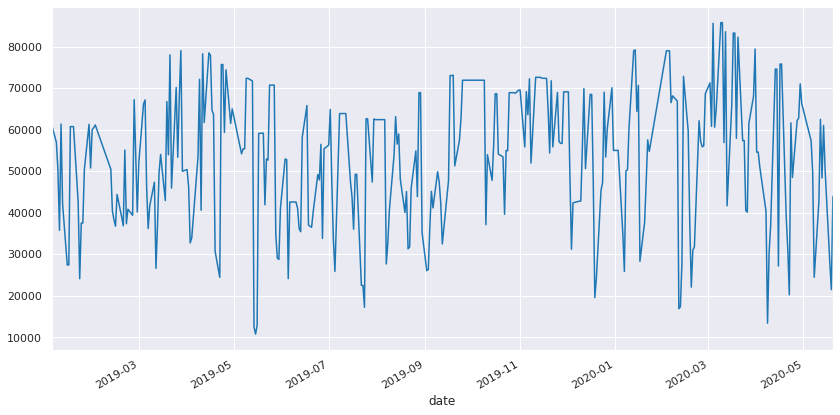

In [9]:
    holdingperc = 3
    safeholding = 5000
    print('*' * 100)
    print('loading data')
    # stockes = getStocklist()
    # stockes = ['600797','000977']
    # data = loadLocalData(stockes,'2018-03-15',end_date = '2019-09-11')
    print('*' * 100)
    print('init account')
    Account = QA.QA_Account(user_cookie='eric', portfolio_cookie='eric')
    Broker = QA.QA_BacktestBroker()
    Account.reset_assets(60000)
    Account.account_cookie = 'ECAP'
    # codelist=['600797','000977','601068','601069','000977']
    # 云计算，华为，5G概念
    codelist3 = QA.QA_fetch_stock_block_adv().get_block('云计算').code[:]
    codelist1 = QA.QA_fetch_stock_block_adv().get_block('华为概念').code[:]
    codelist2 = QA.QA_fetch_stock_block_adv().get_block('5G概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    codelist3.extend(codelist2)
    codelist3.extend(codelist1)

    #
    clist3 = QA.QA_fetch_stock_block_adv().get_block('阿里概念').code[:]
    clist1 = QA.QA_fetch_stock_block_adv().get_block('腾讯概念').code[:]
    clist2 = QA.QA_fetch_stock_block_adv().get_block('小米概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    clist3.extend(clist2)
    clist3.extend(clist1)

    # codelist1.extend(codelist4)
    codelist = list(set(codelist3))

    # codelist = list(set(clist1))
    # data=QA.QA_fetch_stock_day_adv(codelist,'2018-01-01','2019-09-04')
    cur = datetime.datetime.now()
    # endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    endtime = '2020-05-25'
    cl = ['000977', '600745','000810']
    # data = loadLocalData(codelist, '2019-01-01', endtime)
    data = loadLocalData(codelist, '2019-01-01', endtime)
    # data = data.to_qfq()
    print('*' * 100)
    print('prepare data for back test')

    ind = data.add_func(trendSingleNew)
    # around 1/6
    # ind = data.add_func(trendTurn)
    # 1.7/6
    # ind = data.add_func(doubleAvgDay)
    # wired with sudden draw back
    # ind = data.add_func(trendBreak)
    #negative with -4/6
    #ind = data.add_func(doubleAvgminv2)
    # ind = data.add_func(nineTurn)
    # ind=data.add_func(MACACalculate)
    # ind = data.add_func(EMAOP)
    # cur = datetime.datetime.now()
    # endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    data_forbacktest = data.select_time('2019-01-01', endtime)

    for items in data_forbacktest.panel_gen:
        for item in items.security_gen:

            daily_ind = ind.loc[item.index]

            # print(daily_ind)
            if (daily_ind.single.iloc[0] == 1):
                open = QA.QA_fetch_stock_day_adv(item.code[0], item.date[0], item.date[0]).data.open[0] if np.isnan(
                    daily_ind.open.iloc[0]) else item.open[0]
                #close = QA.QA_fetch_stock_day_adv(item.code[0], item.date[0], item.date[0]).data.close[0] if np.isnan(
                    #daily_ind.close.iloc[0]) else item.close[0]
                #print('-----'*10)
                #print('open {} close {}'.format(open,close))
                #print('available {} code {} with {}  at {}  with amount {}'.format(Account.cash_available,item.code[0],(Account.cash_available - safeholding),item.date[0],
                                                                                 # int((Account.cash_available - safeholding) / (holdingperc * open))))
                if ((Account.cash_available - safeholding) / (holdingperc * open) > 100):

                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=int((Account.cash_available - safeholding) / (holdingperc * open*100))*100,
                        # amount = 2000,
                        # amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY,
                        price=open,
                        order_model=QA.ORDER_MODEL.LIMIT,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                    #print('-----{}-------'.format(order))
                    
                else:
                    order = None
                if order:
                        # print('sending order '+'*'*60)
                        Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                        trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                        res = trade_mes.loc[order.account_cookie, order.realorder_id]
                        # print(trade_mes)
                        order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
                        print('*' * 100)
                        print(str(item.date[0]) + " buy " + item.code[0])
            
            
            elif (daily_ind.single.iloc[0] == 3):
                close = QA.QA_fetch_stock_day_adv(item.code[0], item.date[0], item.date[0]).data.close[0] if np.isnan(
                    daily_ind.close.iloc[0]) else item.close[0]
                if Account.sell_available.get(item.code[0], 0) > 0:
                    print('>' * 100)
                    print(str(item.date[0]) + " sell " + item.code[0])
                    # print(int(Account.sell_available.get(item.code[0], 0)))
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],

                        amount=Account.sell_available.get(item.code[0], 0),
                        towards=QA.ORDER_DIRECTION.SELL,
                        # price=(item.close[0]+(item.high[0]-item.close[0])/2),
                        price=close,
                        order_model=QA.ORDER_MODEL.LIMIT,

                        # amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                    if order:
                        Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                        trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                        res = trade_mes.loc[order.account_cookie, order.realorder_id]
                        order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
                # print(res)
        Account.settle()

    print('*' * 100)
    print('analyse account profit')
    Risk = QA.QA_Risk(Account)
    Risk.assets.plot()
    print(Risk.profit_construct)
    print('winning ratio is {}'.format(winRatio(Account)))


In [11]:
Account.history_table[:20]

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message,frozen,direction,total_frozen
0,2019-01-04 00:00:00,002544,11.17,1600,42123.000,Order_wG3MSaLe,Order_wG3MSaLe,Trade_qGi9x7kN,ECAP,5.0,0.000,None,0,1,0
1,2019-01-04 00:00:00,002579,9.08,1300,30314.000,Order_NK7jVFTl,Order_NK7jVFTl,Trade_P54Jg3LQ,ECAP,5.0,0.000,None,0,1,0
2,2019-01-07 00:00:00,000629,3.18,2600,22041.000,Order_jswHkKPM,Order_jswHkKPM,Trade_KO1NrLgj,ECAP,5.0,0.000,None,0,1,0
3,2019-01-07 00:00:00,002387,7.98,700,16450.000,Order_xn1PUjCh,Order_xn1PUjCh,Trade_TRh9gOIy,ECAP,5.0,0.000,None,0,1,0
4,2019-01-07 00:00:00,002456,8.99,400,12849.000,Order_1eHw8lbL,Order_1eHw8lbL,Trade_Hz04DxiG,ECAP,5.0,0.000,None,0,1,0
5,2019-01-07 00:00:00,300167,5.20,500,10244.000,Order_7BIGeE2v,Order_7BIGeE2v,Trade_yG5b6pl1,ECAP,5.0,0.000,None,0,1,0
6,2019-01-07 00:00:00,300207,8.37,200,8565.000,Order_wMVXpY9I,Order_wMVXpY9I,Trade_GEJLaWmy,ECAP,5.0,0.000,None,0,1,0
7,2019-01-07 00:00:00,300397,10.66,100,7494.000,Order_S4K8RtO0,Order_S4K8RtO0,Trade_J9DmOR4Z,ECAP,5.0,0.000,None,0,1,0
8,2019-01-08 00:00:00,000066,5.02,100,6987.000,Order_Z2xdXJfT,Order_Z2xdXJfT,Trade_zuoYkBav,ECAP,5.0,0.000,None,0,1,0
9,2019-01-08 00:00:00,000158,5.30,100,6452.000,Order_uUpMR7mX,Order_uUpMR7mX,Trade_kyesHEYi,ECAP,5.0,0.000,None,0,1,0


****************************************************************************************************
loading data
****************************************************************************************************
init account


QUANTAXIS>> load data from local DB
load data from local DB


****************************************************************************************************
prepare data for back test
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063', '000066', '000070',
       ...
       '688066', '688078', '688080', '688088', '688118', '688158', '688168',
       '688228', '688258', '688369'],
      dtype='object', name='code', length=537)
Index(['000004', '000021', '000034', '000040', '000049', '000050', '000062',
       '000063'

{'date': '2019-01-07 00:00:00', 'code': '300541', 'open': 13.47, 'high': 13.88, 'low': 13.45, 'close': 13.84, 'volume': 21074.0, 'amount': 28953184.0, 'datetime': '2019-01-07 00:00:00'}
ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-01-07 00:00:00 buy 300541
QAACCOUNT ==> receive deal  Time 2019-01-08 00:00:00/ Code:000066/ Price:5.02/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-01-08 00:00:00 buy 000066
failed to deal this order
{'price': 5.02, 'datetime': '2019-01-08 09:30:00', 'date': '2019-01-08', 'sending_time': '2019-01-08 00:00:00', 'trade_time': ['2019-01-08 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '000066', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_mod

{'price': 6.28, 'datetime': '2019-01-08 09:30:00', 'date': '2019-01-08', 'sending_time': '2019-01-08 00:00:00', 'trade_time': ['2019-01-08 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '300051', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_7W3UyjA8', 'realorder_id': 'Order_7W3UyjA8', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_VE9S2f34'], 'trade_price': 6.28, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 628.157, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
6.28
{'date': '2019-01-08 00:00:00', 'code': '300057', 'open': 6.41, 'high': 6.42, 'low': 6.33, 'close': 6.35, 'volume': 8684.0, 'amount': 5525139.5, '

{'price': 4.29, 'datetime': '2019-01-08 09:30:00', 'date': '2019-01-08', 'sending_time': '2019-01-08 00:00:00', 'trade_time': ['2019-01-08 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '300051', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_7W3UyjA8', 'realorder_id': 'Order_7W3UyjA8', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_VE9S2f34'], 'trade_price': 6.28, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 429.10725, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
4.29
{'date': '2019-01-08 00:00:00', 'code': '300202', 'open': 6.68, 'high': 6.78, 'low': 6.63, 'close': 6.68, 'volume': 57898.0, 'amount': 38761356.

{'price': 4.29, 'datetime': '2019-01-08 09:30:00', 'date': '2019-01-08', 'sending_time': '2019-01-08 00:00:00', 'trade_time': ['2019-01-08 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '300051', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_7W3UyjA8', 'realorder_id': 'Order_7W3UyjA8', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_VE9S2f34'], 'trade_price': 6.28, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 429.10725, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
4.29
{'date': '2019-01-08 00:00:00', 'code': '300331', 'open': 11.53, 'high': 12.07, 'low': 11.5, 'close': 11.98, 'volume': 40627.0, 'amount': 481253

{'price': 3.73, 'datetime': '2019-01-08 09:30:00', 'date': '2019-01-08', 'sending_time': '2019-01-08 00:00:00', 'trade_time': ['2019-01-08 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '300051', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_7W3UyjA8', 'realorder_id': 'Order_7W3UyjA8', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_VE9S2f34'], 'trade_price': 6.28, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 373.09325, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
3.73
{'date': '2019-01-08 00:00:00', 'code': '300458', 'open': 20.31, 'high': 20.66, 'low': 20.2, 'close': 20.5, 'volume': 44800.0, 'amount': 9162642

{'price': 3.73, 'datetime': '2019-01-08 09:30:00', 'date': '2019-01-08', 'sending_time': '2019-01-08 00:00:00', 'trade_time': ['2019-01-08 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '300051', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_7W3UyjA8', 'realorder_id': 'Order_7W3UyjA8', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_VE9S2f34'], 'trade_price': 6.28, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 373.09325, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
3.73
{'date': '2019-01-08 00:00:00', 'code': '300566', 'open': 13.01, 'high': 13.28, 'low': 12.99, 'close': 13.24, 'volume': 9957.0, 'amount': 131090

{'price': 3.73, 'datetime': '2019-01-08 09:30:00', 'date': '2019-01-08', 'sending_time': '2019-01-08 00:00:00', 'trade_time': ['2019-01-08 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '300051', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_7W3UyjA8', 'realorder_id': 'Order_7W3UyjA8', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_VE9S2f34'], 'trade_price': 6.28, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 373.09325, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
3.73
{'date': '2019-01-08 00:00:00', 'code': '600728', 'open': 7.12, 'high': 7.29, 'low': 7.08, 'close': 7.09, 'volume': 191201.0, 'amount': 13677198

QAACCOUNT ==> receive deal  Time 2019-01-10 00:00:00/ Code:300167/ Price:5.41/ TOWARDS:-1/ Amounts:200
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-01-10 00:00:00 sell 300207
QAACCOUNT ==> receive deal  Time 2019-01-10 00:00:00/ Code:300207/ Price:8.73/ TOWARDS:-1/ Amounts:100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-01-10 00:00:00 sell 300221
QAACCOUNT ==> receive deal  Time 2019-01-10 00:00:00/ Code:300221/ Price:5.63/ TOWARDS:-1/ Amounts:4400
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-01-10 00:00:00 sell 300414
QAACCOUNT ==> receive deal  Time 2019-01-10 00:00:00/ Code:300414/ Price:15.48/ TOWARDS:-1/ Amounts:800
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-01-11 00:00:00 sell 000971
QAACCOUNT ==> receive deal  Time 2019-01-11 00:00:00/ 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-01-28 00:00:00 sell 002786
QAACCOUNT ==> receive deal  Time 2019-01-28 00:00:00/ Code:002786/ Price:8.33/ TOWARDS:-1/ Amounts:2400
QAACCOUNT ==> receive deal  Time 2019-01-29 00:00:00/ Code:000925/ Price:6.76/ TOWARDS:1/ Amounts:4500
****************************************************************************************************
2019-01-29 00:00:00 buy 000925
QAACCOUNT ==> receive deal  Time 2019-01-29 00:00:00/ Code:300493/ Price:9.93/ TOWARDS:1/ Amounts:1500
****************************************************************************************************
2019-01-29 00:00:00 buy 300493
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-01-30 00:00:00 sell 000925
QAACCOUNT ==> receive deal  Time 2019-01-30 00:00:00/ Code:000925/ Price:6.75/ TOWARDS:-1/ Amounts:4500
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

{'price': 8.13, 'datetime': '2019-02-13 09:30:00', 'date': '2019-02-13', 'sending_time': '2019-02-13 00:00:00', 'trade_time': ['2019-02-13 00:00:00'], 'amount': 400, 'trade_amount': 400, 'cancel_amount': 0, 'towards': 1, 'code': '300085', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_4hiYp1Cf', 'realorder_id': 'Order_4hiYp1Cf', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_HunmEXtY'], 'trade_price': 8.13, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 3252.8130000000006, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
8.13
{'date': '2019-02-13 00:00:00', 'code': '603496', 'open': 25.32, 'high': 25.97, 'low': 25.32, 'close': 25.65, 'volume': 16924.0, 'amoun

2019-02-19 00:00:00 buy 300579
QAACCOUNT ==> receive deal  Time 2019-02-19 00:00:00/ Code:600745/ Price:26.35/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-02-19 00:00:00 buy 600745
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-02-19 00:00:00 sell 603322
QAACCOUNT ==> receive deal  Time 2019-02-19 00:00:00/ Code:603322/ Price:31.14/ TOWARDS:-1/ Amounts:100
QAACCOUNT ==> receive deal  Time 2019-02-20 00:00:00/ Code:000066/ Price:6.26/ TOWARDS:1/ Amounts:700
****************************************************************************************************
2019-02-20 00:00:00 buy 000066
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-02-20 00:00:00 sell 000917
QAACCOUNT ==> receive deal  Time 2019-02-20 00:00:00/ Code:000917/ Price:6.73/ TOWARDS:-1/ Amounts:400
>>>>>>>>>>>>>>>>>>>>>>>>>>>

failed to deal this order
{'price': 7.18, 'datetime': '2019-02-25 09:30:00', 'date': '2019-02-25', 'sending_time': '2019-02-25 00:00:00', 'trade_time': ['2019-02-25 00:00:00'], 'amount': 200, 'trade_amount': 200, 'cancel_amount': 0, 'towards': 1, 'code': '002231', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_dE3LGJvj', 'realorder_id': 'Order_dE3LGJvj', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_dvmRjeys'], 'trade_price': 7.18, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 1436.3590000000002, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
7.18
{'date': '2019-02-25 00:00:00', 'code': '002768', 'open': 22.82, 'high': 25.04, 'low': 22.55, 'close': 23.82,

****************************************************************************************************
2019-02-28 00:00:00 buy 300339
QAACCOUNT ==> receive deal  Time 2019-02-28 00:00:00/ Code:300367/ Price:11.15/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-02-28 00:00:00 buy 300367
failed to deal this order
{'price': 11.15, 'datetime': '2019-02-28 09:30:00', 'date': '2019-02-28', 'sending_time': '2019-02-28 00:00:00', 'trade_time': ['2019-02-28 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '300367', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_8LPUmwfz', 'realorder_id': 'Order_8LPUmwfz', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_t4YJ7V39'], 'trade_price': 11.15, 'broker': 'ba

QAACCOUNT ==> receive deal  Time 2019-03-05 00:00:00/ Code:300290/ Price:8.0/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-03-05 00:00:00 buy 300290
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-05 00:00:00 sell 300339
QAACCOUNT ==> receive deal  Time 2019-03-05 00:00:00/ Code:300339/ Price:13.51/ TOWARDS:-1/ Amounts:100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-05 00:00:00 sell 300367
QAACCOUNT ==> receive deal  Time 2019-03-05 00:00:00/ Code:300367/ Price:12.29/ TOWARDS:-1/ Amounts:100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-06 00:00:00 sell 000004
QAACCOUNT ==> receive deal  Time 2019-03-06 00:00:00/ Code:000004/ Price:19.02/ TOWARDS:-1/ Amounts:1700
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

{'price': 9.51, 'datetime': '2019-03-07 09:30:00', 'date': '2019-03-07', 'sending_time': '2019-03-07 00:00:00', 'trade_time': ['2019-03-07 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '300433', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_InPyOXQR', 'realorder_id': 'Order_InPyOXQR', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_E3okCvWm'], 'trade_price': 9.51, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 951.2377500000001, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
9.51
{'date': '2019-03-07 00:00:00', 'code': '300608', 'open': 26.33, 'high': 26.37, 'low': 25.53, 'close': 26.0, 'volume': 21204.0, 'amount'

{'price': 4.44, 'datetime': '2019-03-07 09:30:00', 'date': '2019-03-07', 'sending_time': '2019-03-07 00:00:00', 'trade_time': ['2019-03-07 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '600237', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_GnRSQ4J5', 'realorder_id': 'Order_GnRSQ4J5', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_ZPLF0qrg'], 'trade_price': 4.44, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 444.1110000000001, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
4.44
{'date': '2019-03-07 00:00:00', 'code': '603118', 'open': 8.5, 'high': 8.65, 'low': 8.33, 'close': 8.48, 'volume': 218454.0, 'amount': 1

QAACCOUNT ==> receive deal  Time 2019-03-08 00:00:00/ Code:300433/ Price:8.81/ TOWARDS:-1/ Amounts:100
QAACCOUNT ==> receive deal  Time 2019-03-08 00:00:00/ Code:300476/ Price:14.4/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2019-03-08 00:00:00 buy 300476
QAACCOUNT ==> receive deal  Time 2019-03-08 00:00:00/ Code:600225/ Price:3.64/ TOWARDS:1/ Amounts:1100
****************************************************************************************************
2019-03-08 00:00:00 buy 600225
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-08 00:00:00 sell 600237
QAACCOUNT ==> receive deal  Time 2019-03-08 00:00:00/ Code:600237/ Price:4.52/ TOWARDS:-1/ Amounts:100
QAACCOUNT ==> receive deal  Time 2019-03-11 00:00:00/ Code:002174/ Price:22.03/ TOWARDS:1/ Amounts:100
*****************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-13 00:00:00 sell 300212
QAACCOUNT ==> receive deal  Time 2019-03-13 00:00:00/ Code:300212/ Price:27.59/ TOWARDS:-1/ Amounts:300
QAACCOUNT ==> receive deal  Time 2019-03-13 00:00:00/ Code:300349/ Price:22.91/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2019-03-13 00:00:00 buy 300349
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-13 00:00:00 sell 300383
QAACCOUNT ==> receive deal  Time 2019-03-13 00:00:00/ Code:300383/ Price:18.75/ TOWARDS:-1/ Amounts:500
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-13 00:00:00 sell 300469
QAACCOUNT ==> receive deal  Time 2019-03-13 00:00:00/ Code:300469/ Price:25.43/ TOWARDS:-1/ Amounts:400
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

QAACCOUNT ==> receive deal  Time 2019-03-25 00:00:00/ Code:300229/ Price:11.96/ TOWARDS:-1/ Amounts:1600
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-25 00:00:00 sell 300245
QAACCOUNT ==> receive deal  Time 2019-03-25 00:00:00/ Code:300245/ Price:11.28/ TOWARDS:-1/ Amounts:900
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-25 00:00:00 sell 600718
QAACCOUNT ==> receive deal  Time 2019-03-25 00:00:00/ Code:600718/ Price:14.82/ TOWARDS:-1/ Amounts:300
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-26 00:00:00 sell 300075
QAACCOUNT ==> receive deal  Time 2019-03-26 00:00:00/ Code:300075/ Price:12.88/ TOWARDS:-1/ Amounts:200
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-03-26 00:00:00 sell 300115
QAACCOUNT ==> receive deal  Time 2019-03-26 00:00:0

2019-04-04 00:00:00 buy 002268
QAACCOUNT ==> receive deal  Time 2019-04-04 00:00:00/ Code:300020/ Price:10.18/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2019-04-04 00:00:00 buy 300020
QAACCOUNT ==> receive deal  Time 2019-04-04 00:00:00/ Code:300098/ Price:10.48/ TOWARDS:1/ Amounts:200
****************************************************************************************************
2019-04-04 00:00:00 buy 300098
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-04-04 00:00:00 sell 300290
QAACCOUNT ==> receive deal  Time 2019-04-04 00:00:00/ Code:300290/ Price:10.31/ TOWARDS:-1/ Amounts:1900
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-04-04 00:00:00 sell 600751
QAACCOUNT ==> receive deal  Time 2019-04-04 00:00:00/ Code:600751/ Price:4.16/ TOWARDS:-1/ Amounts:800
QAACCOUNT ==> receive dea

QAACCOUNT ==> receive deal  Time 2019-04-22 00:00:00/ Code:002757/ Price:35.55/ TOWARDS:-1/ Amounts:900
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-04-22 00:00:00 sell 300207
QAACCOUNT ==> receive deal  Time 2019-04-22 00:00:00/ Code:300207/ Price:14.01/ TOWARDS:-1/ Amounts:1100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-04-22 00:00:00 sell 300394
QAACCOUNT ==> receive deal  Time 2019-04-22 00:00:00/ Code:300394/ Price:33.82/ TOWARDS:-1/ Amounts:200
QAACCOUNT ==> receive deal  Time 2019-04-22 00:00:00/ Code:300565/ Price:16.44/ TOWARDS:1/ Amounts:2100
****************************************************************************************************
2019-04-22 00:00:00 buy 300565
QAACCOUNT ==> receive deal  Time 2019-04-22 00:00:00/ Code:600487/ Price:23.45/ TOWARDS:1/ Amounts:700
**********************************************************************************

{'price': 3.69, 'datetime': '2019-05-14 09:30:00', 'date': '2019-05-14', 'sending_time': '2019-05-14 00:00:00', 'trade_time': ['2019-05-14 00:00:00'], 'amount': 700, 'trade_amount': 700, 'cancel_amount': 0, 'towards': 1, 'code': '600601', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_y25Bz0Fl', 'realorder_id': 'Order_y25Bz0Fl', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_uUm5Wtd0'], 'trade_price': 3.69, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 2583.64575, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
3.69
{'date': '2019-05-14 00:00:00', 'code': '603712', 'open': 19.9, 'high': 21.25, 'low': 19.61, 'close': 20.72, 'volume': 133457.0, 'amount': 2745

{'date': '2019-05-16 00:00:00', 'code': '300235', 'open': 9.75, 'high': 9.79, 'low': 9.56, 'close': 9.77, 'volume': 36377.0, 'amount': 35233124.0, 'datetime': '2019-05-16 00:00:00'}
ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-05-16 00:00:00 buy 300235
ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-05-16 00:00:00 buy 300264
failed to deal this order
{'price': 5.5, 'datetime': '2019-05-16 09:30:00', 'date': '2019-05-16', 'sending_time': '2019-05-16 00:00:00', 'trade_time': ['2019-05-16 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '002148', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_DpvNCJ

****************************************************************************************************
2019-05-17 00:00:00 buy 002845
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-05-17 00:00:00 sell 300066
QAACCOUNT ==> receive deal  Time 2019-05-17 00:00:00/ Code:300066/ Price:4.85/ TOWARDS:-1/ Amounts:9000
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-05-17 00:00:00 sell 300290
QAACCOUNT ==> receive deal  Time 2019-05-17 00:00:00/ Code:300290/ Price:10.71/ TOWARDS:-1/ Amounts:1800
QAACCOUNT ==> receive deal  Time 2019-05-17 00:00:00/ Code:300345/ Price:7.1/ TOWARDS:1/ Amounts:4500
****************************************************************************************************
2019-05-17 00:00:00 buy 300345
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-05-17 00:00:00 sell 600203
QAACCOUNT ==> receive deal

QAACCOUNT ==> receive deal  Time 2019-05-30 00:00:00/ Code:603918/ Price:14.44/ TOWARDS:1/ Amounts:1000
****************************************************************************************************
2019-05-30 00:00:00 buy 603918
QAACCOUNT ==> receive deal  Time 2019-05-31 00:00:00/ Code:002935/ Price:50.02/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-05-31 00:00:00 buy 002935
QAACCOUNT ==> receive deal  Time 2019-05-31 00:00:00/ Code:300458/ Price:22.23/ TOWARDS:1/ Amounts:200
****************************************************************************************************
2019-05-31 00:00:00 buy 300458
failed to deal this order
{'price': 22.23, 'datetime': '2019-05-31 09:30:00', 'date': '2019-05-31', 'sending_time': '2019-05-31 00:00:00', 'trade_time': ['2019-05-31 00:00:00'], 'amount': 200, 'trade_amount': 200, 'cancel_amount': 0, 'towards': 1, 'code': '300458', 'user_cookie': 'eric', 'mark

{'price': 20.03, 'datetime': '2019-06-12 09:30:00', 'date': '2019-06-12', 'sending_time': '2019-06-12 00:00:00', 'trade_time': ['2019-06-12 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '002860', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_soIj5t6y', 'realorder_id': 'Order_soIj5t6y', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_NaZYR9cF'], 'trade_price': 20.03, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 2003.5007500000002, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
20.03
{'date': '2019-06-12 00:00:00', 'code': '002938', 'open': 25.68, 'high': 26.38, 'low': 25.5, 'close': 25.88, 'volume': 46280.0, 'amo

****************************************************************************************************
2019-06-21 00:00:00 buy 002796
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-06-21 00:00:00 sell 300202
QAACCOUNT ==> receive deal  Time 2019-06-21 00:00:00/ Code:300202/ Price:7.48/ TOWARDS:-1/ Amounts:4800
QAACCOUNT ==> receive deal  Time 2019-06-21 00:00:00/ Code:300308/ Price:34.54/ TOWARDS:1/ Amounts:600
****************************************************************************************************
2019-06-21 00:00:00 buy 300308
QAACCOUNT ==> receive deal  Time 2019-06-21 00:00:00/ Code:300468/ Price:17.12/ TOWARDS:1/ Amounts:600
****************************************************************************************************
2019-06-21 00:00:00 buy 300468
QAACCOUNT ==> receive deal  Time 2019-06-21 00:00:00/ Code:300579/ Price:28.4/ TOWARDS:1/ Amounts:200
***********************************************************

{'price': 7.11, 'datetime': '2019-06-28 09:30:00', 'date': '2019-06-28', 'sending_time': '2019-06-28 00:00:00', 'trade_time': ['2019-06-28 00:00:00'], 'amount': 300, 'trade_amount': 300, 'cancel_amount': 0, 'towards': 1, 'code': '002660', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_56VHKmkN', 'realorder_id': 'Order_56VHKmkN', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_lRFoCxgh'], 'trade_price': 7.11, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 2133.53325, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
7.11
{'date': '2019-06-28 00:00:00', 'code': '300205', 'open': 15.7, 'high': 15.74, 'low': 14.8, 'close': 14.96, 'volume': 147888.0, 'amount': 22354

QAACCOUNT ==> receive deal  Time 2019-07-18 00:00:00/ Code:300274/ Price:10.12/ TOWARDS:-1/ Amounts:1000
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-07-18 00:00:00 sell 300394
QAACCOUNT ==> receive deal  Time 2019-07-18 00:00:00/ Code:300394/ Price:31.36/ TOWARDS:-1/ Amounts:100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-07-18 00:00:00 sell 300560
QAACCOUNT ==> receive deal  Time 2019-07-18 00:00:00/ Code:300560/ Price:17.08/ TOWARDS:-1/ Amounts:200
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-07-22 00:00:00 sell 002938
QAACCOUNT ==> receive deal  Time 2019-07-22 00:00:00/ Code:002938/ Price:31.61/ TOWARDS:-1/ Amounts:700
QAACCOUNT ==> receive deal  Time 2019-07-22 00:00:00/ Code:300041/ Price:9.24/ TOWARDS:1/ Amounts:3400
*********************************************************************************

{'price': 6.62, 'datetime': '2019-08-14 09:30:00', 'date': '2019-08-14', 'sending_time': '2019-08-14 00:00:00', 'trade_time': ['2019-08-14 00:00:00'], 'amount': 1300, 'trade_amount': 1300, 'cancel_amount': 0, 'towards': 1, 'code': '002436', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_7cTWHZJL', 'realorder_id': 'Order_7cTWHZJL', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_ZvEHygen'], 'trade_price': 6.62, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 8608.1515, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
6.62
{'date': '2019-08-14 00:00:00', 'code': '300709', 'open': 63.0, 'high': 63.85, 'low': 60.13, 'close': 61.39, 'volume': 19465.0, 'amount': 1203

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-08-20 00:00:00 sell 300687
QAACCOUNT ==> receive deal  Time 2019-08-20 00:00:00/ Code:300687/ Price:14.46/ TOWARDS:-1/ Amounts:100
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-08-21 00:00:00 sell 002426
QAACCOUNT ==> receive deal  Time 2019-08-21 00:00:00/ Code:002426/ Price:2.72/ TOWARDS:-1/ Amounts:1000
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-08-21 00:00:00 sell 002467
QAACCOUNT ==> receive deal  Time 2019-08-21 00:00:00/ Code:002467/ Price:5.44/ TOWARDS:-1/ Amounts:3700
QAACCOUNT ==> receive deal  Time 2019-08-21 00:00:00/ Code:300083/ Price:3.12/ TOWARDS:1/ Amounts:6400
****************************************************************************************************
2019-08-21 00:00:00 buy 300083
QAACCOUNT ==> receive deal  Time 2019-08-21 00:00:00/ 

****************************************************************************************************
2019-09-03 00:00:00 buy 002212
QAACCOUNT ==> receive deal  Time 2019-09-03 00:00:00/ Code:300245/ Price:10.13/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2019-09-03 00:00:00 buy 300245
QAACCOUNT ==> receive deal  Time 2019-09-03 00:00:00/ Code:300367/ Price:5.7/ TOWARDS:1/ Amounts:200
****************************************************************************************************
2019-09-03 00:00:00 buy 300367
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-09-03 00:00:00 sell 300770
QAACCOUNT ==> receive deal  Time 2019-09-03 00:00:00/ Code:300770/ Price:93.7/ TOWARDS:-1/ Amounts:100
QAACCOUNT ==> receive deal  Time 2019-09-03 00:00:00/ Code:603496/ Price:19.92/ TOWARDS:1/ Amounts:200
*************************************************************

{'date': '2019-09-09 00:00:00', 'code': '002387', 'open': 16.83, 'high': 16.85, 'low': 16.28, 'close': 16.66, 'volume': 90167.0, 'amount': 149603312.0, 'datetime': '2019-09-09 00:00:00'}
ORDER STATUS success_all CANNNOT TRADE
****************************************************************************************************
2019-09-09 00:00:00 buy 002387
failed to deal this order
{'price': 5.59, 'datetime': '2019-09-09 09:30:00', 'date': '2019-09-09', 'sending_time': '2019-09-09 00:00:00', 'trade_time': ['2019-09-09 00:00:00'], 'amount': 400, 'trade_amount': 400, 'cancel_amount': 0, 'towards': 1, 'code': '002341', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_B21pemOW', 'realorder_id': 'Order_B21pemOW', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_lqLwI2RB'], 'trade_price': 5.59, 'broker': 'backtest', 'c

QAACCOUNT ==> receive deal  Time 2019-09-11 00:00:00/ Code:603118/ Price:13.13/ TOWARDS:-1/ Amounts:800
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-09-11 00:00:00 sell 603228
QAACCOUNT ==> receive deal  Time 2019-09-11 00:00:00/ Code:603228/ Price:49.59/ TOWARDS:-1/ Amounts:200
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-09-11 00:00:00 sell 603328
QAACCOUNT ==> receive deal  Time 2019-09-11 00:00:00/ Code:603328/ Price:13.23/ TOWARDS:-1/ Amounts:700
QAACCOUNT ==> receive deal  Time 2019-09-11 00:00:00/ Code:603803/ Price:15.49/ TOWARDS:1/ Amounts:1100
****************************************************************************************************
2019-09-11 00:00:00 buy 603803
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-09-12 00:00:00 sell 000555
QAACCOUNT ==> receive deal  Time 2019-09-12 00:00:00/

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-10-11 00:00:00 sell 300068
QAACCOUNT ==> receive deal  Time 2019-10-11 00:00:00/ Code:300068/ Price:11.67/ TOWARDS:-1/ Amounts:3100
QAACCOUNT ==> receive deal  Time 2019-10-11 00:00:00/ Code:300378/ Price:16.95/ TOWARDS:1/ Amounts:1600
****************************************************************************************************
2019-10-11 00:00:00 buy 300378
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-10-11 00:00:00 sell 603700
QAACCOUNT ==> receive deal  Time 2019-10-11 00:00:00/ Code:603700/ Price:25.7/ TOWARDS:-1/ Amounts:700
QAACCOUNT ==> receive deal  Time 2019-10-14 00:00:00/ Code:002241/ Price:18.75/ TOWARDS:1/ Amounts:1200
****************************************************************************************************
2019-10-14 00:00:00 buy 002241
QAACCOUNT ==> receive deal  Time 2019-10-14 00:00:00/ 

****************************************************************************************************
2019-11-19 00:00:00 buy 000066
QAACCOUNT ==> receive deal  Time 2019-11-19 00:00:00/ Code:000977/ Price:30.9/ TOWARDS:1/ Amounts:600
****************************************************************************************************
2019-11-19 00:00:00 buy 000977
QAACCOUNT ==> receive deal  Time 2019-11-19 00:00:00/ Code:002368/ Price:35.81/ TOWARDS:1/ Amounts:200
****************************************************************************************************
2019-11-19 00:00:00 buy 002368
QAACCOUNT ==> receive deal  Time 2019-11-19 00:00:00/ Code:300211/ Price:7.41/ TOWARDS:1/ Amounts:900
****************************************************************************************************
2019-11-19 00:00:00 buy 300211
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-11-20 00:00:00 sell 000066
QAACCOUNT ==> receive deal  Time

{'price': 24.11, 'datetime': '2019-12-10 09:30:00', 'date': '2019-12-10', 'sending_time': '2019-12-10 00:00:00', 'trade_time': ['2019-12-10 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '002555', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_pL3YicVm', 'realorder_id': 'Order_pL3YicVm', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_9zdYXHSE'], 'trade_price': 24.11, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 2411.60275, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
24.11
{'date': '2019-12-10 00:00:00', 'code': '300770', 'open': 119.86, 'high': 120.5, 'low': 117.2, 'close': 119.76, 'volume': 14272.0, 'amount':

****************************************************************************************************
2019-12-27 00:00:00 buy 300134
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-12-27 00:00:00 sell 300263
QAACCOUNT ==> receive deal  Time 2019-12-27 00:00:00/ Code:300263/ Price:5.39/ TOWARDS:-1/ Amounts:4700
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-12-30 00:00:00 sell 300134
QAACCOUNT ==> receive deal  Time 2019-12-30 00:00:00/ Code:300134/ Price:15.52/ TOWARDS:-1/ Amounts:700
QAACCOUNT ==> receive deal  Time 2019-12-31 00:00:00/ Code:000555/ Price:14.35/ TOWARDS:1/ Amounts:1600
****************************************************************************************************
2019-12-31 00:00:00 buy 000555
QAACCOUNT ==> receive deal  Time 2019-12-31 00:00:00/ Code:300098/ Price:5.95/ TOWARDS:1/ Amounts:2100
*******************************************************

QAACCOUNT ==> receive deal  Time 2020-01-13 00:00:00/ Code:002301/ Price:13.11/ TOWARDS:1/ Amounts:800
****************************************************************************************************
2020-01-13 00:00:00 buy 002301
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-01-13 00:00:00 sell 300373
QAACCOUNT ==> receive deal  Time 2020-01-13 00:00:00/ Code:300373/ Price:19.77/ TOWARDS:-1/ Amounts:1700
QAACCOUNT ==> receive deal  Time 2020-01-13 00:00:00/ Code:688023/ Price:167.79/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2020-01-13 00:00:00 buy 688023
QAACCOUNT ==> receive deal  Time 2020-01-14 00:00:00/ Code:002368/ Price:40.9/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2020-01-14 00:00:00 buy 002368
QAACCOUNT ==> receive deal  Time 2020-01-14 00:00:00/ Cod

****************************************************************************************************
2020-02-06 00:00:00 buy 300188
QAACCOUNT ==> receive deal  Time 2020-02-10 00:00:00/ Code:002439/ Price:41.4/ TOWARDS:1/ Amounts:200
****************************************************************************************************
2020-02-10 00:00:00 buy 002439
failed to deal this order
{'price': 41.4, 'datetime': '2020-02-10 09:30:00', 'date': '2020-02-10', 'sending_time': '2020-02-10 00:00:00', 'trade_time': ['2020-02-10 00:00:00'], 'amount': 200, 'trade_amount': 200, 'cancel_amount': 0, 'towards': 1, 'code': '002439', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_yi8wVvL9', 'realorder_id': 'Order_yi8wVvL9', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_sKBG0S3P'], 'trade_price': 41.4, 'broker': 'backt

{'price': 7.13, 'datetime': '2020-02-11 09:30:00', 'date': '2020-02-11', 'sending_time': '2020-02-11 00:00:00', 'trade_time': ['2020-02-11 00:00:00'], 'amount': 100, 'trade_amount': 100, 'cancel_amount': 0, 'towards': 1, 'code': '603528', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_XtZYqAg0', 'realorder_id': 'Order_XtZYqAg0', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_nxjCcdJU'], 'trade_price': 7.13, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 713.17825, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
7.13
{'date': '2020-02-11 00:00:00', 'code': '603912', 'open': 14.21, 'high': 14.6, 'low': 13.94, 'close': 14.24, 'volume': 60715.0, 'amount': 867763

QAACCOUNT ==> receive deal  Time 2020-02-17 00:00:00/ Code:300212/ Price:43.99/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2020-02-17 00:00:00 buy 300212
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-02-18 00:00:00 sell 002860
QAACCOUNT ==> receive deal  Time 2020-02-18 00:00:00/ Code:002860/ Price:23.68/ TOWARDS:-1/ Amounts:200
QAACCOUNT ==> receive deal  Time 2020-02-18 00:00:00/ Code:300369/ Price:26.85/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2020-02-18 00:00:00 buy 300369
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-02-18 00:00:00 sell 300376
QAACCOUNT ==> receive deal  Time 2020-02-18 00:00:00/ Code:300376/ Price:5.23/ TOWARDS:-1/ Amounts:2600
QAACCOUNT ==> receive deal  Time 2020-02-18 00:00:00/ Co

****************************************************************************************************
2020-02-21 00:00:00 buy 603160
QAACCOUNT ==> receive deal  Time 2020-02-24 00:00:00/ Code:000810/ Price:15.9/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2020-02-24 00:00:00 buy 000810
failed to deal this order
{'price': 15.9, 'datetime': '2020-02-24 09:30:00', 'date': '2020-02-24', 'sending_time': '2020-02-24 00:00:00', 'trade_time': ['2020-02-24 00:00:00'], 'amount': 400, 'trade_amount': 400, 'cancel_amount': 0, 'towards': 1, 'code': '000810', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_uJCFZcx7', 'realorder_id': 'Order_uJCFZcx7', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_MKlxYJec'], 'trade_price': 15.9, 'broker': 'backt

QAACCOUNT ==> receive deal  Time 2020-02-25 00:00:00/ Code:600850/ Price:29.39/ TOWARDS:1/ Amounts:100
****************************************************************************************************
2020-02-25 00:00:00 buy 600850
QAACCOUNT ==> receive deal  Time 2020-02-25 00:00:00/ Code:601789/ Price:3.9/ TOWARDS:1/ Amounts:1000
****************************************************************************************************
2020-02-25 00:00:00 buy 601789
failed to deal this order
{'price': 3.9, 'datetime': '2020-02-25 09:30:00', 'date': '2020-02-25', 'sending_time': '2020-02-25 00:00:00', 'trade_time': ['2020-02-25 00:00:00'], 'amount': 1000, 'trade_amount': 1000, 'cancel_amount': 0, 'towards': 1, 'code': '601789', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_QgnlYr91', 'realorder_id': 'Order_QgnlYr91', 'commission_co

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-03-03 00:00:00 sell 000938
QAACCOUNT ==> receive deal  Time 2020-03-03 00:00:00/ Code:000938/ Price:46.6/ TOWARDS:-1/ Amounts:200
QAACCOUNT ==> receive deal  Time 2020-03-03 00:00:00/ Code:600225/ Price:2.56/ TOWARDS:1/ Amounts:4500
****************************************************************************************************
2020-03-03 00:00:00 buy 600225
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-03-04 00:00:00 sell 000928
QAACCOUNT ==> receive deal  Time 2020-03-04 00:00:00/ Code:000928/ Price:5.21/ TOWARDS:-1/ Amounts:4900
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-03-04 00:00:00 sell 002011
QAACCOUNT ==> receive deal  Time 2020-03-04 00:00:00/ Code:002011/ Price:5.19/ TOWARDS:-1/ Amounts:1400
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

****************************************************************************************************
2020-03-26 00:00:00 buy 600105
QAACCOUNT ==> receive deal  Time 2020-03-26 00:00:00/ Code:600590/ Price:6.37/ TOWARDS:1/ Amounts:900
****************************************************************************************************
2020-03-26 00:00:00 buy 600590
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-03-26 00:00:00 sell 603330
QAACCOUNT ==> receive deal  Time 2020-03-26 00:00:00/ Code:603330/ Price:15.31/ TOWARDS:-1/ Amounts:2800
QAACCOUNT ==> receive deal  Time 2020-03-26 00:00:00/ Code:603882/ Price:54.81/ TOWARDS:1/ Amounts:400
****************************************************************************************************
2020-03-26 00:00:00 buy 603882
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-03-27 00:00:00 sell 002463
QAACCOUNT ==> receive deal  

QAACCOUNT ==> receive deal  Time 2020-04-09 00:00:00/ Code:002860/ Price:27.32/ TOWARDS:-1/ Amounts:700
QAACCOUNT ==> receive deal  Time 2020-04-09 00:00:00/ Code:300083/ Price:5.28/ TOWARDS:1/ Amounts:2100
****************************************************************************************************
2020-04-09 00:00:00 buy 300083
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-04-09 00:00:00 sell 300218
QAACCOUNT ==> receive deal  Time 2020-04-09 00:00:00/ Code:300218/ Price:8.99/ TOWARDS:-1/ Amounts:1400
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-04-09 00:00:00 sell 300241
QAACCOUNT ==> receive deal  Time 2020-04-09 00:00:00/ Code:300241/ Price:5.58/ TOWARDS:-1/ Amounts:3500
QAACCOUNT ==> receive deal  Time 2020-04-09 00:00:00/ Code:300259/ Price:5.22/ TOWARDS:1/ Amounts:4100
************************************************************************************

{'price': 13.75, 'datetime': '2020-04-21 09:30:00', 'date': '2020-04-21', 'sending_time': '2020-04-21 00:00:00', 'trade_time': ['2020-04-21 00:00:00'], 'amount': 800, 'trade_amount': 800, 'cancel_amount': 0, 'towards': 1, 'code': '002706', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_Zqz50QDN', 'realorder_id': 'Order_Zqz50QDN', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_OV8ftDW4'], 'trade_price': 13.75, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 11002.750000000002, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
13.75
{'date': '2020-04-21 00:00:00', 'code': '300502', 'open': 71.0, 'high': 72.95, 'low': 70.01, 'close': 72.9, 'volume': 61113.0, 'amou

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-04-29 00:00:00 sell 002232
QAACCOUNT ==> receive deal  Time 2020-04-29 00:00:00/ Code:002232/ Price:8.8/ TOWARDS:-1/ Amounts:1900
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-04-29 00:00:00 sell 688008
QAACCOUNT ==> receive deal  Time 2020-04-29 00:00:00/ Code:688008/ Price:92.23/ TOWARDS:-1/ Amounts:100
QAACCOUNT ==> receive deal  Time 2020-04-30 00:00:00/ Code:002384/ Price:24.74/ TOWARDS:1/ Amounts:1400
****************************************************************************************************
2020-04-30 00:00:00 buy 002384
QAACCOUNT ==> receive deal  Time 2020-04-30 00:00:00/ Code:002475/ Price:46.8/ TOWARDS:1/ Amounts:300
****************************************************************************************************
2020-04-30 00:00:00 buy 002475
QAACCOUNT ==> receive deal  Time 2020-05-06 00:00:00/ Cod

{'price': 11.55, 'datetime': '2020-05-07 09:30:00', 'date': '2020-05-07', 'sending_time': '2020-05-07 00:00:00', 'trade_time': ['2020-05-07 00:00:00'], 'amount': 200, 'trade_amount': 200, 'cancel_amount': 0, 'towards': 1, 'code': '600522', 'user_cookie': 'eric', 'market_type': 'stock_cn', 'frequence': 'day', 'account_cookie': 'ECAP', 'strategy': None, 'type': 'stock_cn', 'order_model': 'LIMIT', 'amount_model': 'by_amount', 'order_id': 'Order_4TzGUyVi', 'realorder_id': 'Order_4TzGUyVi', 'commission_coeff': 0.00025, 'tax_coeff': 0.001, 'trade_id': ['Trade_dnKkEAe7'], 'trade_price': 11.55, 'broker': 'backtest', 'callback': <bound method QA_Account.receive_deal of < QA_Account ECAP market: stock_cn>>, 'money': 2310.5775000000003, 'reason': None, 'exchange_id': None, 'time_condition': 'GFD', '_status': 'success_all', 'direction': 'BUY', 'offset': 'OPEN'}
11.55
{'date': '2020-05-07 00:00:00', 'code': '600588', 'open': 48.3, 'high': 48.31, 'low': 46.28, 'close': 46.62, 'volume': 189504.0, 'am

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-05-12 00:00:00 sell 600522
QAACCOUNT ==> receive deal  Time 2020-05-12 00:00:00/ Code:600522/ Price:12.4/ TOWARDS:-1/ Amounts:200
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-05-12 00:00:00 sell 603319
QAACCOUNT ==> receive deal  Time 2020-05-12 00:00:00/ Code:603319/ Price:19.99/ TOWARDS:-1/ Amounts:200
QAACCOUNT ==> receive deal  Time 2020-05-13 00:00:00/ Code:300182/ Price:4.41/ TOWARDS:1/ Amounts:3800
****************************************************************************************************
2020-05-13 00:00:00 buy 300182
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2020-05-14 00:00:00 sell 002341
QAACCOUNT ==> receive deal  Time 2020-05-14 00:00:00/ Code:002341/ Price:5.37/ TOWARDS:-1/ Amounts:4300
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

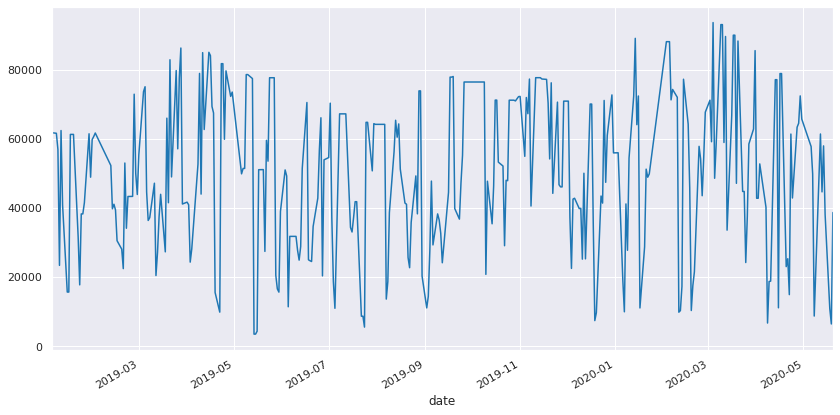

In [12]:
    holdingperc = 2
    safeholding = 500
    print('*' * 100)
    print('loading data')
    # stockes = getStocklist()
    # stockes = ['600797','000977']
    # data = loadLocalData(stockes,'2018-03-15',end_date = '2019-09-11')
    print('*' * 100)
    print('init account')
    Account = QA.QA_Account(user_cookie='eric', portfolio_cookie='eric')
    Broker = QA.QA_BacktestBroker()
    Account.reset_assets(60000)
    Account.account_cookie = 'ECAP'
    # codelist=['600797','000977','601068','601069','000977']
    # 云计算，华为，5G概念
    codelist3 = QA.QA_fetch_stock_block_adv().get_block('云计算').code[:]
    codelist1 = QA.QA_fetch_stock_block_adv().get_block('华为概念').code[:]
    codelist2 = QA.QA_fetch_stock_block_adv().get_block('5G概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    codelist1.extend(codelist2)
    codelist1.extend(codelist3)

    #
    clist3 = QA.QA_fetch_stock_block_adv().get_block('阿里概念').code[:]
    clist1 = QA.QA_fetch_stock_block_adv().get_block('腾讯概念').code[:]
    clist2 = QA.QA_fetch_stock_block_adv().get_block('小米概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    clist1.extend(clist2)
    clist1.extend(clist3)

    # codelist1.extend(codelist4)
    codelist = list(set(codelist1))
   

    # codelist = list(set(clist1))
    # data=QA.QA_fetch_stock_day_adv(codelist,'2018-01-01','2019-09-04')
    cur =datetime.datetime.now()
    #endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    endtime = '2020-05-25'
    cl = ['000977','600745']
    #data = loadLocalData(codelist, '2019-01-01', endtime)
    data = loadLocalData(codelist,'2019-01-01',endtime)
    #data = data.to_qfq()
    print('*' * 100)
    print('prepare data for back test')

    ind = data.add_func(trendSingleNew)
    #around 1/6
    #ind = data.add_func(trendTurn)
    #1.7/6
    #ind = data.add_func(doubleAvgDay)
    #wired with sudden draw back
    #ind = data.add_func(trendBreak)
    #ind = data.add_func(doubleAvgmin)
    #ind = data.add_func(nineTurn)
    # ind=data.add_func(MACACalculate)
    #ind = data.add_func(EMAOP)
    #cur = datetime.datetime.now()
    #endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    data_forbacktest = data.select_time('2019-01-01',endtime)

    for items in data_forbacktest.panel_gen:
        for item in items.security_gen:

            daily_ind = ind.loc[item.index]
            # print(daily_ind)
            if (daily_ind.single.iloc[0] == 1):
                if ((Account.cash_available - safeholding) / (holdingperc * item.open[0]) > 100):
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=int((Account.cash_available - safeholding) / (holdingperc * item.open[0]*100))*100,
                        # amount = 2000,
                        # amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY,
                        price=item.open[0],
                        order_model=QA.ORDER_MODEL.LIMIT,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                # print(item.to_json()[0])
                if order:
                    # print('sending order '+'*'*60)
                    Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                    trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                    res = trade_mes.loc[order.account_cookie, order.realorder_id]
                    # print(trade_mes)
                    order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
                    print('*' * 100)
                    print(str(item.date[0]) + " buy " + item.code[0])
                # print (res)
            elif (daily_ind.single.iloc[0] == 3):
                if Account.sell_available.get(item.code[0], 0) > 0:
                    print('>' * 100)
                    print(str(item.date[0]) + " sell " + item.code[0])
                    # print(int(Account.sell_available.get(item.code[0], 0)))
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],

                        amount=Account.sell_available.get(item.code[0], 0),
                        towards=QA.ORDER_DIRECTION.SELL,
                        #price=(item.close[0]+(item.high[0]-item.close[0])/2),
                        price = item.close[0],
                        order_model=QA.ORDER_MODEL.LIMIT,

                        #amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        amount_model = QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                    if order:
                        Broker.receive_order(QA.QA_Event(order=order, market_data=item))

                        trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                        res = trade_mes.loc[order.account_cookie, order.realorder_id]
                        order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
                # print(res)
        Account.settle()

    print('*' * 100)
    print('analyse account profit')
    Risk = QA.QA_Risk(Account)
    Risk.assets.plot()
    print(Risk.profit_construct)
    print('winning ratio is {}'.format(winRatio(Account)))


In [37]:
Account.cash_table

cash             datetime       date  \
datetime            account_cookie                                              
2019-01-07 00:00:00 ECAP            4.058e+04  2019-01-07 00:00:00 2019-01-07   
                    ECAP            2.725e+04  2019-01-07 00:00:00 2019-01-07   
                    ECAP            1.856e+04  2019-01-07 00:00:00 2019-01-07   
                    ECAP            1.278e+04  2019-01-07 00:00:00 2019-01-07   
                    ECAP                 9036  2019-01-07 00:00:00 2019-01-07   
                    ECAP                 6421  2019-01-07 00:00:00 2019-01-07   
                    ECAP                 4958  2019-01-07 00:00:00 2019-01-07   
                    ECAP                 4263  2019-01-07 00:00:00 2019-01-07   
                    ECAP                 3156  2019-01-07 00:00:00 2019-01-07   
                    ECAP                 2331  2019-01-07 00:00:00 2019-01-07   
...                                       ...                  ...        ...   
2020-03-10 00:00:00 ECAP                 3772  2020-03-10 00:00:00 2020-03-10   
                    ECAP                 2879  2020-03-10 00:00:00 2020-03-10   
2020-03-12 00:00:00 ECAP                 2565  2020-03-12 00:00:00 2020-03-12   
2020-03-17 00:00:00 ECAP                 3739  2020-03-17 00:00:00 2020-03-17   
                    ECAP                 7444  2020-03-17 00:00:00 2020-03-17   
2020-03-18 00:00:00 ECAP                 5558  2020-03-18 00:00:00 2020-03-18   
2020-03-20 00:00:00 ECAP                 4526  2020-03-20 00:00:00 2020-03-20   
2020-03-23 00:00:00 ECAP                 3759  2020-03-23 00:00:00 2020-03-23   
                    ECAP                 2923  2020-03-23 00:00:00 2020-03-23   
2020-04-07 00:00:00 ECAP                 2442  2020-04-07 00:00:00 2020-04-07   

                                   account_cookie  
datetime            account_cookie                 
2019-01-07 00:00:00 ECAP                     ECAP  
                    ECAP                     ECAP  
                    ECAP                     ECAP  
                    ECAP                     ECAP  
                    ECAP                     ECAP  
                    ECAP                     ECAP  
                    ECAP                     ECAP  
                    ECAP                     ECAP  
                    ECAP                     ECAP  
                    ECAP                     ECAP  
...                                           ...  
2020-03-10 00:00:00 ECAP                     ECAP  
                    ECAP                     ECAP  
2020-03-12 00:00:00 ECAP                     ECAP  
2020-03-17 00:00:00 ECAP                     ECAP  
                    ECAP                     ECAP  
2020-03-18 00:00:00 ECAP                     ECAP  
2020-03-20 00:00:00 ECAP                     ECAP  
2020-03-23 00:00:00 ECAP                     ECAP  
                    ECAP                     ECAP  
2020-04-07 00:00:00 ECAP                     ECAP  

[150 rows x 4 columns]

In [28]:
sample = QA.QA_fetch_stock_day_adv('000977','2019-01-01','2019-05-31').data

sample

In [30]:
test = trendBreak(sample)

In [32]:
import quant.Util as uti

In [33]:
import quant.MACD as macd 

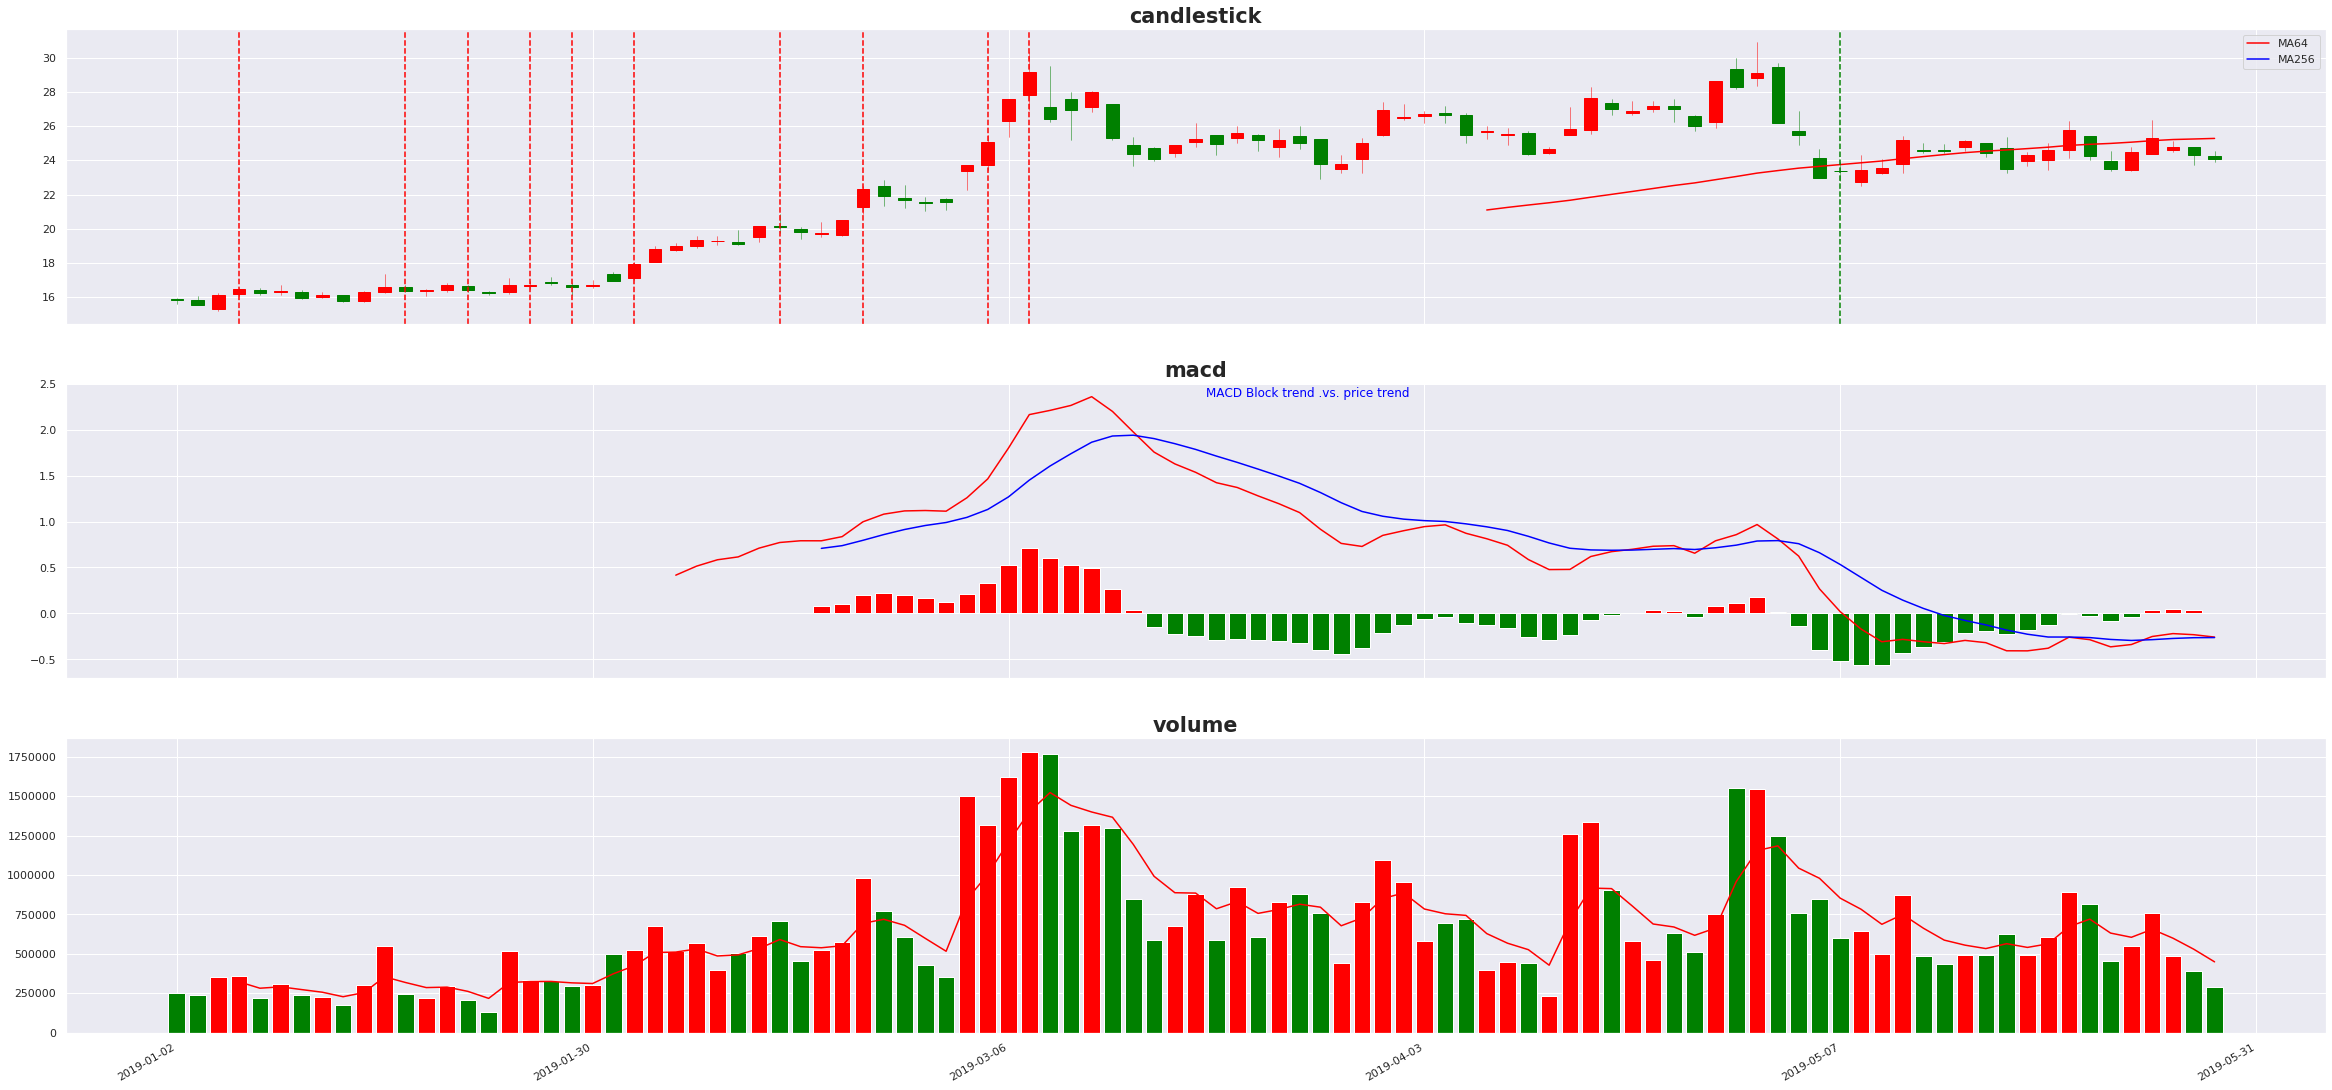

In [36]:
macd.MINMACACalculate(sample)
macd.MINMACDPLOT(sample,uti.dayindex,uti.dayformate)